# Table of Contents <a id="back_to_top"></a>
* [Introduction](#section1)
* [Goals](#section2)
* [Libraries and Packagaes](#section3)
* [Data](#section4)
    * [Load Data](#section4.1)
    * [Inspect Data](#section4.2)
        * [Train Set](#section4.2.1)
        * [Test Set](#section4.2.2)
    * [Check Data Types](#section4.3)
        * [Train Set](#section4.3.1)
        * [Test Set](#section4.3.2)
* [Cleaning Data](#section5)
    * [Missing Values - Categorical](#section5.1)
        * [Train Set](#section5.1.1)
        * [Test Set](#section5.1.2)
    * [Missing Values - Numerical](#section5.2)
        * [Train Set](#section5.2.1)
        * [Test Set](#section5.2.2)
    * [Correlation Matrix](#section5.3)
        * [Train Set](#section5.3.1)
        * [Test Set](#section5.3.2)
* [Exploratory Data Analysis](#section6)
* [Feature Transformations](#section7)
    * [Normailty - Log Transformation](#section7.1)
    * [Seasonality - Cosine Transformation](#section7.2)
    * [Target Transformation](#section7.3)
* [Encoding Data](#section8)
    * [Ordinal Values](#section8.1)
    * [Categorical Values](#section8.2)
    * [Removing & Splitting](#section8.3)
* [Scaling Data](#section0) *"Phantom" Section*
* [Model Selection](#section9)
    * [Not Scaled](#section9.1)
    * [Scaled](#section9.2) *"Phantom" Section*
* [Base Line Model](#section10)
* [Hyperparameter Tuning](#section11)
    * [Version 1 - Not Scaled](#section11.1)
    * [Version 1 - Scaled](#section11.2) *"Phantom" Section*
* [Ensemble](#section12)
* [Submissions/Final Predictions](#section13)
    * [Version 1 - Not Scaled](#section13.1)
    * [Version 1 - Scaled](#section13.2) *"Phantom" Section*
    * [Version 2 - Not Scaled](#section13.3)
* [Conclusion](#section14)

# Introduction <a class="anchor" id="section1"></a>
This Notebook contains analysis of a Kaggle competition of residential homes in Ames, Iowa from 2006-2010. With many factors to take into account, determining the value of a house can be a difficult thing to do. This is why using a predictive model can be so useful. They can aid sellers in pricing their home while also aiding buyers to make informed decisions.

The data and information regarding the features of the data for this project can be found [here](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data). Also the license to be found [here](https://www.mit.edu/~amini/LICENSE.md).

# Goals <a class="anchor" id="section2"></a>
The goals for this project is the following:

* Get acquainted with the data
* Clean the data to be ready for analysis
* Analyze features to reveal patterns and insight (EDA)
* Gather insight into how the features relate to the prediction term (`SalePrice`) 
* Transform the data to be compatible with ML algorithms (preprocessing)
* Predict the `SalePrice` for the test set and submit results

# Libraries and Packages <a class="anchor" id="section3"></a>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV

from pycaret.regression import setup, compare_models
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor

import optuna

# Data <a class="anchor" id="section4"></a>
The shape of the data in this project is 1460 rows by 81 columns for the Train Set and 1459 rows by 80 columns for the Test Set. Out of the 80 features/variables, 45% are numerical, and the remaining 55% are categorical. There are 79 features that can be used to predict `saleprice`. The feature that is not relevant in predicting `saleprice` is the `id` column. While making assumptions, some notable features at first glance could be: `lotarea` , `neighborhood` , `overallcond` , `centralair`, `heatingqc`, `grlivarea`, `bldgtype`, `functional`, `mosold`, and `yrsold`. Regarding the `yrsold` feature, there is some historical precedent ([Housing Bubble](https://www.investopedia.com/ask/answers/100314/when-did-real-estate-bubble-burst.asp)) when the US housing market took quite a tumble and led to the [GFC](https://www.rba.gov.au/education/resources/explainers/the-global-financial-crisis.html).

## Load Data <a class="anchor" id="section4.1"></a>

In [2]:
# Loading in the csv files
train_og = pd.read_csv("train.csv")
test_og = pd.read_csv("test.csv")

# Making copies to save original data sets before making changes to them
train0 = train_og.copy()
test0 = test_og.copy()

# Changing the columns to lowercase for ease of use & displaying all columns at once
train0.columns = [x.lower() for x in train0.columns]
test0.columns = [x.lower() for x in test0.columns]
pd.set_option("display.max_columns", None)

## Inspect Data <a class="anchor" id="section4.2"></a>
Here, basic exploration of the data begins, revealing numerous missing values in the datasets. Additionaly, basic descriptive statistics are computed for the numerical features of the datasets.

### Train Set <a class="anchor" id="section4.2.1"></a>

In [3]:
train0

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,

In [4]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [5]:
train0.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
pd.set_option("display.max_rows", 82)
train0.isna().sum().sort_values(ascending=False).head(20)

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
masvnrtype       872
fireplacequ      690
lotfrontage      259
garageyrblt       81
garagecond        81
garagetype        81
garagefinish      81
garagequal        81
bsmtfintype2      38
bsmtexposure      38
bsmtqual          37
bsmtcond          37
bsmtfintype1      37
masvnrarea         8
electrical         1
id                 0
dtype: int64

### Test Set <a class="anchor" id="section4.2.2"></a>

In [7]:
test0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1459 non-null   int64  
 1   mssubclass     1459 non-null   int64  
 2   mszoning       1455 non-null   object 
 3   lotfrontage    1232 non-null   float64
 4   lotarea        1459 non-null   int64  
 5   street         1459 non-null   object 
 6   alley          107 non-null    object 
 7   lotshape       1459 non-null   object 
 8   landcontour    1459 non-null   object 
 9   utilities      1457 non-null   object 
 10  lotconfig      1459 non-null   object 
 11  landslope      1459 non-null   object 
 12  neighborhood   1459 non-null   object 
 13  condition1     1459 non-null   object 
 14  condition2     1459 non-null   object 
 15  bldgtype       1459 non-null   object 
 16  housestyle     1459 non-null   object 
 17  overallqual    1459 non-null   int64  
 18  overallc

In [8]:
test0.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [9]:
pd.set_option("display.max_rows", 82)
test0.isna().sum().sort_values(ascending=False).head(35)

poolqc          1456
miscfeature     1408
alley           1352
fence           1169
masvnrtype       894
fireplacequ      730
lotfrontage      227
garageyrblt       78
garagequal        78
garagefinish      78
garagecond        78
garagetype        76
bsmtcond          45
bsmtqual          44
bsmtexposure      44
bsmtfintype1      42
bsmtfintype2      42
masvnrarea        15
mszoning           4
bsmthalfbath       2
utilities          2
functional         2
bsmtfullbath       2
bsmtfinsf1         1
bsmtfinsf2         1
bsmtunfsf          1
kitchenqual        1
totalbsmtsf        1
exterior2nd        1
garagecars         1
exterior1st        1
garagearea         1
saletype           1
miscval            0
bedroomabvgr       0
dtype: int64

## Check Data Types <a class="anchor" id="section4.3"></a>
While reviewing the [data documentation](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data), it was discovered that the `mssubclass` feature contains numerical values, although it is intended to be a categorical feature.

### Train Set <a class="anchor" id="section4.3.1"></a>

In [10]:
train0.dtypes[train0.dtypes != "object"]

id                 int64
mssubclass         int64
lotfrontage      float64
lotarea            int64
overallqual        int64
overallcond        int64
yearbuilt          int64
yearremodadd       int64
masvnrarea       float64
bsmtfinsf1         int64
bsmtfinsf2         int64
bsmtunfsf          int64
totalbsmtsf        int64
1stflrsf           int64
2ndflrsf           int64
lowqualfinsf       int64
grlivarea          int64
bsmtfullbath       int64
bsmthalfbath       int64
fullbath           int64
halfbath           int64
bedroomabvgr       int64
kitchenabvgr       int64
totrmsabvgrd       int64
fireplaces         int64
garageyrblt      float64
garagecars         int64
garagearea         int64
wooddecksf         int64
openporchsf        int64
enclosedporch      int64
3ssnporch          int64
screenporch        int64
poolarea           int64
miscval            int64
mosold             int64
yrsold             int64
saleprice          int64
dtype: object

In [11]:
train0.mssubclass = train0.mssubclass.astype(str)

In [12]:
train0.select_dtypes(np.number)

,id,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
0,1,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,1457,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,1458,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,68.0,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,142125


In [13]:
train0.dtypes[train0.dtypes == "object"]

mssubclass       object
mszoning         object
street           object
alley            object
lotshape         object
landcontour      object
utilities        object
lotconfig        object
landslope        object
neighborhood     object
condition1       object
condition2       object
bldgtype         object
housestyle       object
roofstyle        object
roofmatl         object
exterior1st      object
exterior2nd      object
masvnrtype       object
exterqual        object
extercond        object
foundation       object
bsmtqual         object
bsmtcond         object
bsmtexposure     object
bsmtfintype1     object
bsmtfintype2     object
heating          object
heatingqc        object
centralair       object
electrical       object
kitchenqual      object
functional       object
fireplacequ      object
garagetype       object
garagefinish     object
garagequal       object
garagecond       object
paveddrive       object
poolqc           object
fence            object
miscfeature     

### Train Set <a class="anchor" id="section1.3.2"></a>

In [14]:
test0.dtypes[test0.dtypes != "object"]

id                 int64
mssubclass         int64
lotfrontage      float64
lotarea            int64
overallqual        int64
overallcond        int64
yearbuilt          int64
yearremodadd       int64
masvnrarea       float64
bsmtfinsf1       float64
bsmtfinsf2       float64
bsmtunfsf        float64
totalbsmtsf      float64
1stflrsf           int64
2ndflrsf           int64
lowqualfinsf       int64
grlivarea          int64
bsmtfullbath     float64
bsmthalfbath     float64
fullbath           int64
halfbath           int64
bedroomabvgr       int64
kitchenabvgr       int64
totrmsabvgrd       int64
fireplaces         int64
garageyrblt      float64
garagecars       float64
garagearea       float64
wooddecksf         int64
openporchsf        int64
enclosedporch      int64
3ssnporch          int64
screenporch        int64
poolarea           int64
miscval            int64
mosold             int64
yrsold             int64
dtype: object

In [15]:
test0.mssubclass = train0.mssubclass.astype(str)

In [16]:
test0.select_dtypes(np.number)

,id,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold
0,1461,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010
1,1462,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010
2,1463,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010
3,1464,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,1998.0,2.0,470.0,360,36,0,0,0,0,0,6,2010
4,1465,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,1992.0,2.0,506.0,0,82,0,0,144,0,0,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,546.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,5,0,NaN,0.0,0.0,0,0,0,0,0,0,0,6,2006
1455,2916,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,294.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,6,0,1970.0,1.0,286.0,0,24,0,0,0,0,0,4,2006
1456,2917,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,0.0,1224.0,1224,0,0,1224,1.0,0.0,1,0,4,1,7,1,1960.0,2.0,576.0,474,0,0,0,0,0,0,9,2006
1457,2918,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,575.0,912.0,970,0,0,970,0.0,1.0,1,0,3,1,6,0,NaN,0.0,0.0,80,32,0,0,0,0,700,7,2006


In [17]:
test0.dtypes[test0.dtypes == "object"]

mssubclass       object
mszoning         object
street           object
alley            object
lotshape         object
landcontour      object
utilities        object
lotconfig        object
landslope        object
neighborhood     object
condition1       object
condition2       object
bldgtype         object
housestyle       object
roofstyle        object
roofmatl         object
exterior1st      object
exterior2nd      object
masvnrtype       object
exterqual        object
extercond        object
foundation       object
bsmtqual         object
bsmtcond         object
bsmtexposure     object
bsmtfintype1     object
bsmtfintype2     object
heating          object
heatingqc        object
centralair       object
electrical       object
kitchenqual      object
functional       object
fireplacequ      object
garagetype       object
garagefinish     object
garagequal       object
garagecond       object
paveddrive       object
poolqc           object
fence            object
miscfeature     

# Cleaning Data <a class="anchor" id="section5"></a>
The majority of the missing values in the datasets are [Missing Not at Random (MNAR)](https://www.ncbi.nlm.nih.gov/books/NBK493614/#:~:text=Missing%20not%20at%20random%20(MNAR,not%20measured%20by%20the%20researcher.), mostly due to how they are denoted in the [data documentation](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data). While the rest of the missing values are [Missing Completely at Random (MCAR)](https://www.ncbi.nlm.nih.gov/books/NBK493614/#:~:text=Missing%20not%20at%20random%20(MNAR,not%20measured%20by%20the%20researcher.).

## Missing Values - Categorical <a class="anchor" id="section5.1"></a>

### Train Set <a class="anchor" id="section5.1.1"></a>

In [18]:
# Checking for missing values
train0.select_dtypes("object").isna().sum()

mssubclass          0
mszoning            0
street              0
alley            1369
lotshape            0
landcontour         0
utilities           0
lotconfig           0
landslope           0
neighborhood        0
condition1          0
condition2          0
bldgtype            0
housestyle          0
roofstyle           0
roofmatl            0
exterior1st         0
exterior2nd         0
masvnrtype        872
exterqual           0
extercond           0
foundation          0
bsmtqual           37
bsmtcond           37
bsmtexposure       38
bsmtfintype1       37
bsmtfintype2       38
heating             0
heatingqc           0
centralair          0
electrical          1
kitchenqual         0
functional          0
fireplacequ       690
garagetype         81
garagefinish       81
garagequal         81
garagecond         81
paveddrive          0
poolqc           1453
fence            1179
miscfeature      1406
saletype            0
salecondition       0
dtype: int64

In [19]:
# Features where missing values are found
train0.select_dtypes("object").loc[:,train0.isna().sum() > 0].columns

Index(['alley', 'masvnrtype', 'bsmtqual', 'bsmtcond', 'bsmtexposure',
       'bsmtfintype1', 'bsmtfintype2', 'electrical', 'fireplacequ',
       'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'poolqc',
       'fence', 'miscfeature'],
      dtype='object')

In [20]:
# Impute the actuall values
for r in ["alley", "masvnrtype", "bsmtqual", "bsmtcond", "bsmtexposure", "bsmtfintype1", "bsmtfintype2", "fireplacequ", 
         "garagetype", "garagefinish", "garagequal", "garagecond", "poolqc", "fence", "miscfeature"]:
    train0[r] = train0[r].fillna("None")
    
# Impute the mode
for r in ["electrical"]:
    train0[r] = train0[r].fillna(train0[r].mode()[0])

In [21]:
train0.select_dtypes("object").isna().sum().sum()

0

### Test Set <a class="anchor" id="section5.1.2"></a>

In [22]:
# Checking for missing values
test0.select_dtypes("object").isna().sum()

mssubclass          0
mszoning            4
street              0
alley            1352
lotshape            0
landcontour         0
utilities           2
lotconfig           0
landslope           0
neighborhood        0
condition1          0
condition2          0
bldgtype            0
housestyle          0
roofstyle           0
roofmatl            0
exterior1st         1
exterior2nd         1
masvnrtype        894
exterqual           0
extercond           0
foundation          0
bsmtqual           44
bsmtcond           45
bsmtexposure       44
bsmtfintype1       42
bsmtfintype2       42
heating             0
heatingqc           0
centralair          0
electrical          0
kitchenqual         1
functional          2
fireplacequ       730
garagetype         76
garagefinish       78
garagequal         78
garagecond         78
paveddrive          0
poolqc           1456
fence            1169
miscfeature      1408
saletype            1
salecondition       0
dtype: int64

In [23]:
# Fetures where missing values are found
test0.select_dtypes("object").loc[:,test0.isna().sum() > 0].columns

Index(['mszoning', 'alley', 'utilities', 'exterior1st', 'exterior2nd',
       'masvnrtype', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1',
       'bsmtfintype2', 'kitchenqual', 'functional', 'fireplacequ',
       'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'poolqc',
       'fence', 'miscfeature', 'saletype'],
      dtype='object')

In [24]:
# Impute the actuall values
for r in ["alley", "masvnrtype", "bsmtqual", "bsmtcond", "bsmtexposure", "bsmtfintype1", "bsmtfintype2", "fireplacequ", 
         "garagetype", "garagefinish", "garagequal", "garagecond", "poolqc", "fence", "miscfeature"]:
    test0[r] = test0[r].fillna("None")
    
# Impute the mode
for r in ["utilities", "kitchenqual", "functional", "saletype"]:
    test0[r] = test0[r].fillna(test0[r].mode()[0])
    
# Fill NaN values in "mszoning" column based on mode of each neighborhood
test0["mszoning"] = test0["mszoning"].fillna(test0.groupby("neighborhood")["mszoning"].transform(lambda x: x.mode()[0]))

# Fill NaN values in "exterior1st" and "exterior2nd" column based on mode of each neighborhood
test0["exterior1st"] = test0["exterior1st"].fillna(test0.groupby("neighborhood")["exterior1st"].transform(lambda x: x.mode()[0]))
test0["exterior2nd"] = test0["exterior2nd"].fillna(test0.groupby("neighborhood")["exterior2nd"].transform(lambda x: x.mode()[0]))

In [25]:
test0.select_dtypes("object").isna().sum().sum()

0

## Missing Values - Numerical <a class="anchor" id="section5.2"></a>

### Train Set <a class="anchor" id="section5.2.1"></a>

In [26]:
# Cheching for missing values
train0.select_dtypes(np.number).isna().sum()

id                 0
lotfrontage      259
lotarea            0
overallqual        0
overallcond        0
yearbuilt          0
yearremodadd       0
masvnrarea         8
bsmtfinsf1         0
bsmtfinsf2         0
bsmtunfsf          0
totalbsmtsf        0
1stflrsf           0
2ndflrsf           0
lowqualfinsf       0
grlivarea          0
bsmtfullbath       0
bsmthalfbath       0
fullbath           0
halfbath           0
bedroomabvgr       0
kitchenabvgr       0
totrmsabvgrd       0
fireplaces         0
garageyrblt       81
garagecars         0
garagearea         0
wooddecksf         0
openporchsf        0
enclosedporch      0
3ssnporch          0
screenporch        0
poolarea           0
miscval            0
mosold             0
yrsold             0
saleprice          0
dtype: int64

In [27]:
# Features where missing values are found
train0.select_dtypes(np.number).loc[:,train0.isna().sum() > 0].columns

Index(['lotfrontage', 'masvnrarea', 'garageyrblt'], dtype='object')

In [28]:
# starting with feature with least amount of missing values, and inspect that they don't have veneer on the house
train0[train0.masvnrarea.isna()]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
234,235,60,RL,NaN,7851,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625,Unf,0,235,860,GasA,Ex,Y,SBrkr,860,1100,0,1960,1,0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2,440,TA,TA,Y,288,48,0,0,0,0,None,None,None,0,5,2010,WD,Normal,216500
529,530,20,RL,NaN,32668,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,None,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,None,None,None,0,3,2007,WD,Alloca,200624
650,651,60,FV,65.0,8125,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,None,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,None,Attchd,2007.0,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal,205950
936,937,20,RL,67.0,10083,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,833,Unf,0,343,1176,GasA,Ex,Y,SBrkr,1200,0,0,1200,1,0,2,0,2,1,Gd,5,Typ,0,None,Attchd,2003.0,RFn,2,555,TA,TA,Y,0,41,0,0,0,0,None,None,None,0,8,2009,WD,Normal,184900
973,974,20,FV,95.0,11639,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,None,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1428,1428,GasA,Ex,Y,SBrkr,1428,0,0,1428,0,0,2,0,3,1,Gd,6,Typ,0,None,Attchd,2007.0,Fin,2,480,TA,TA,Y,0,120,0,0,0,0,None,None,None,0,12,2008,New,Partial,182000
977,978,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,1106,Unf,0,135,1241,GasA,Ex,Y,SBrkr,1241,0,0,1241,1,0,1,1,1,1,Gd,4,Typ,0,None,Attchd,2007.0,Fin,2,569,TA,TA,Y,0,116,0,0,0,0,None,None,None,0,11,2007,New,Partial,199900
1243,1244,20,RL,107.0,13891,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386,Unf,0,690,2076,GasA,Ex,Y,SBrkr,2076,0,0,2076,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3,850,TA,TA,Y,216,229,0,0,0,0,None,None,None,0,9,2006,New,Partial,465000
1278,1279,60,RL,75.0,9473,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,804,Unf,0,324,1128,GasA,Ex,Y,SBrkr,1128,903,0,2031,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2,577,TA,TA,Y,0,211,0,0,0,0,None,None,None,0,3,2008,WD,Normal,237000


In [29]:
# Missing values can be imputed by hand to zero because there isn't any veneer on the house
train0.masvnrarea = train0.masvnrarea.fillna(0.0)

In [30]:
# Lots of missing values. Holding off until later
train0[train0.lotfrontage.isna()]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
12,13,20,RL,NaN,12968,Pave,None,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,737,Unf,0,175,912,GasA,TA,Y,SBrkr,912,0,0,912,1,0,1,0,2,1,TA,4,Typ,0,None,Detchd,1962.0,Unf,1,352,TA,TA,Y,140,0,0,0,176,0,None,None,None,0,9,2008,WD,Normal,144000
14,15,20,RL,NaN,10920,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,MetalSd,MetalSd,BrkFace,212.0,TA,TA,CBlock,TA,TA,No,BLQ,733,Unf,0,520,1253,GasA,TA,Y,SBrkr,1253,0,0,1253,1,0,1,1,2,1,TA,5,Typ,1,Fa,Attchd,1960.0,RFn,1,352,TA,TA,Y,0,213,176,0,0,0,None,GdWo,None,0,5,2008,WD,Normal,157000
16,17,20,RL,NaN,11241,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578,Unf,0,426,1004,GasA,Ex,Y,SBrkr,1004,0,0,1004,1,0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2,480,TA,TA,Y,0,0,0,0,0,0,None,None,Shed,700,3,2010,WD,Normal,149000
24,25,20,RL,NaN,8246,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1968,2001,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,TA,TA,Mn,Rec,188,ALQ,668,204,1060,GasA,Ex,Y,SBrkr,1060,0,0,1060,1,0,1,0,3,1,Gd,6,Typ,1,TA,Attchd,1968.0,Unf,1,270,TA,TA,Y,406,90,0,0,0,0,None,MnPrv,None,0,5,2010,WD,Normal,154000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,1430,20,RL,NaN,12546,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,7,1981,1981,Gable,CompShg,MetalSd,MetalSd,BrkFace,310.0,Gd,Gd,CBlock,Gd,TA,No,BLQ,678,Unf,0,762,1440,GasA,Ex,Y,SBrkr,1440,0,0,1440,0,0,2,0,3,1,Gd,7,Typ,1,TA,Attchd,1981.0,Fin,2,467,TA,TA,Y,0,0,99,0,0,0,None,None,None,0,4,2007,WD,Normal,182900
1431,1432,120,RL,NaN,4928,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NPkVill,Norm,Norm,TwnhsE,1Story,6,6,1976,1976,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,LwQ,958,Unf,0,0,958,GasA,TA,Y,SBrkr,958,0,0,958,0,0,2,0,2,1,TA,5,Typ,0,None,Attchd,1976.0,RFn,2,440,TA,TA,Y,0,60,0,0,0,0,None,None,None,0,10,2009,WD,Normal,143750
1441,1442,120,RM,NaN,4426,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,TwnhsE,1Story,6,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,147.0,Gd,TA,PConc,Gd,TA,Av,GLQ,697,Unf,0,151,848,GasA,Ex,Y,SBrkr,848,0,0,848,1,0,1,0,1,1,Gd,3,Typ,1,TA,Attchd,2004.0,RFn,2,420,TA,TA,Y,149,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal,149300
1443,1444,30,RL,NaN,8854,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1.5Unf,6,6,1916,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,

[ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]


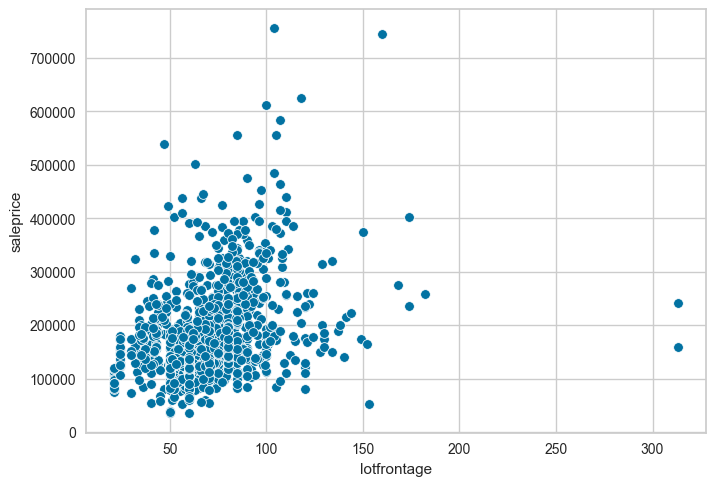

In [31]:
# Looking for correlation with saleprice
print(train0.lotfrontage.unique())


sns.scatterplot(data=train0, x="lotfrontage", y="saleprice")
plt.show()

In [32]:
# Missing values due to the house not having a garage, but not comfortable with putting place holder values ie. 0 for None
# Holding off until later
train0[train0.garageyrblt.isna()]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
39,40,90,RL,65.0,6040,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,None,0.0,TA,TA,PConc,None,None,None,None,0,None,0,0,0,GasA,TA,N,FuseP,1152,0,0,1152,0,0,2,0,2,2,Fa,6,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,0,0,0,0,None,None,None,0,6,2008,WD,AdjLand,82000
48,49,190,RM,33.0,4456,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,5,1920,2008,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,736,736,GasA,Gd,Y,SBrkr,736,716,0,1452,0,0,2,0,2,3,TA,8,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,102,0,0,0,None,None,None,0,6,2009,New,Partial,113000
78,79,90,RL,72.0,10778,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1968,1968,Hip,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1768,1768,GasA,TA,N,SBrkr,1768,0,0,1768,0,0,2,0,4,2,TA,8,Typ,0,None,None,NaN,None,0,0,None,None,Y,0,0,0,0,0,0,None,None,None,0,4,2010,WD,Normal,136500
88,89,50,C (all),105.0,8470,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,TA,N,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,156,0,0,0,None,MnPrv,None,0,10,2009,ConLD,Abnorml,85000
89,90,20,RL,60.0,8070,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,4,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,588,Unf,0,402,990,GasA,Ex,Y,SBrkr,990,0,0,990,1,0,1,0,3,1,TA,5,Typ,0,None,None,NaN,None,0,0,None,None,Y,0,0,0,0,0,0,None,None,None,0,8,2007,WD,Normal,123600
99,100,20,RL,77.0,9320,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1959,1959,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,569,Unf,0,381,950,GasA,Fa,Y,SBrkr,1225,0,0,1225,1,0,1,1,3,1,TA,6,Typ,0,None,None,NaN,None,0,0,None,None,Y,352,0,0,0,0,0,None,None,Shed,400,1,2010,WD,Normal,128950
108,109,50,RM,85.0,8500,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,5,7,1919,2005,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,793,793,GasW,TA,N,FuseF,997,520,0,1517,0,0,2,0,3,1,Fa,7,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,144,0,0,0,None,None,None,0,8,2007,WD,Normal,115000
125,126,190,RM,60.0,6780,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,2fmCon,1.5Fin,6,8,1935,1982,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Fa,CBlock,TA,TA,Av,GLQ,490,Unf,0,30,520,GasA,Gd,N,SBrkr,520,0,234,754,1,0,1,0,2,1,TA,5,Typ,0,None,None,NaN,None,0,0,None,None,N,53,0,0,0,0,0,None,None,None,0,6,2006,WD,Normal,84500
127,128,45,RM,55.0,4388,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,OldTown,Feedr,Norm,1Fam,1.5Unf,5,7,1930,1950,Gable,CompShg,WdShing,Wd Sdng,None,0.0,TA,Gd,BrkTil,TA,TA,No,LwQ,116,Unf,0,556,672,GasA,Ex,Y,SBrkr,840,0,0,840,0,0,1,0,3,1,TA,5,Typ,1,TA,None,NaN,None,0,0,None,None,N,0,0,0,0,0,0,None,None,None,0,6,2007,WD,Normal,87000
140,141,20,RL,70.0,10500,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1971,1971,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,432,Unf,0,432,864

[2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2006. 1960. 1991. 1970. 1967. 1958. 1930. 2002. 1968. 2007. 2008.
 1957. 1920. 1966. 1959. 1995. 1954. 1953.   nan 1983. 1977. 1997. 1985.
 1963. 1981. 1964. 1999. 1935. 1990. 1945. 1987. 1989. 1915. 1956. 1948.
 1974. 2009. 1950. 1961. 1921. 1900. 1979. 1951. 1969. 1936. 1975. 1971.
 1923. 1984. 1926. 1955. 1986. 1988. 1916. 1932. 1972. 1918. 1980. 1924.
 1996. 1940. 1949. 1994. 1910. 1978. 1982. 1992. 1925. 1941. 2010. 1927.
 1947. 1937. 1942. 1938. 1952. 1928. 1922. 1934. 1906. 1914. 1946. 1908.
 1929. 1933.]


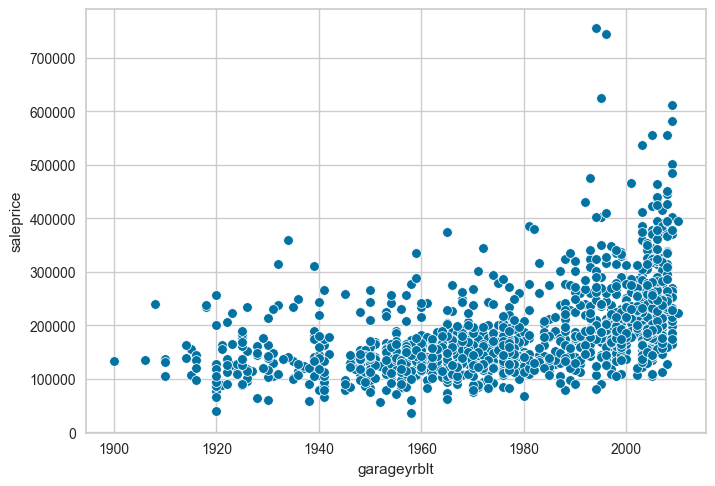

In [33]:
# Looking for correlation with saleprice
print(train0.garageyrblt.unique())


sns.scatterplot(data= train0, x="garageyrblt", y="saleprice")
plt.show()

### Test Set <a class="anchor" id="section5.2.2"></a>

In [34]:
# Checking for missing values
test0.select_dtypes(np.number).isna().sum()

id                 0
lotfrontage      227
lotarea            0
overallqual        0
overallcond        0
yearbuilt          0
yearremodadd       0
masvnrarea        15
bsmtfinsf1         1
bsmtfinsf2         1
bsmtunfsf          1
totalbsmtsf        1
1stflrsf           0
2ndflrsf           0
lowqualfinsf       0
grlivarea          0
bsmtfullbath       2
bsmthalfbath       2
fullbath           0
halfbath           0
bedroomabvgr       0
kitchenabvgr       0
totrmsabvgrd       0
fireplaces         0
garageyrblt       78
garagecars         1
garagearea         1
wooddecksf         0
openporchsf        0
enclosedporch      0
3ssnporch          0
screenporch        0
poolarea           0
miscval            0
mosold             0
yrsold             0
dtype: int64

In [35]:
# list of features that have missing values
# Holding off on "lotfrontage" until later like in the train set
test0.select_dtypes(np.number).loc[:,test0.isna().sum() > 0].columns

Index(['lotfrontage', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf',
       'totalbsmtsf', 'bsmtfullbath', 'bsmthalfbath', 'garageyrblt',
       'garagecars', 'garagearea'],
      dtype='object')

In [36]:
test0[test0.garagecars.isna()]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
1116,2577,80,RM,50.0,9060,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,None,Detchd,NaN,None,NaN,NaN,None,None,Y,174,0,212,0,0,0,None,MnPrv,None,0,3,2007,WD,Alloca


In [37]:
test0.query("(garagetype == 'Detchd') & (yearbuilt == 1923)")

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
76,1537,20,RM,68.0,9656,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,2,2,1923,1970,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,BrkTil,Fa,Fa,No,Unf,0.0,Unf,0.0,678.0,678.0,GasA,TA,N,SBrkr,832,0,0,832,0.0,0.0,1,0,2,1,TA,5,Typ,1,Gd,Detchd,1928.0,Unf,2.0,780.0,Fa,Fa,N,0,0,0,0,0,0,None,None,None,0,6,2010,WD,Abnorml
90,1551,20,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1Story,6,5,1923,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Fa,Fa,No,ALQ,960.0,Unf,0.0,164.0,1124.0,GasA,TA,Y,SBrkr,1068,0,0,1068,1.0,0.0,1,0,2,1,TA,5,Typ,1,Gd,Detchd,1923.0,Unf,1.0,288.0,TA,TA,Y,0,0,128,0,0,0,None,None,None,0,3,2010,WD,Normal
355,1816,20,RM,60.0,8520,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,8,1923,1950,Gable,CompShg,Stucco,Stucco,None,0.0,Gd,TA,PConc,Fa,TA,No,Unf,0.0,Unf,0.0,624.0,624.0,GasA,TA,Y,SBrkr,792,0,0,792,0.0,0.0,1,0,2,1,TA,5,Typ,0,None,Detchd,1963.0,Unf,1.0,287.0,TA,TA,Y,0,0,81,0,0,0,None,GdWo,None,0,2,2009,WD,Normal
664,2125,20,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,2Story,5,5,1923,1950,Gambrel,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,LwQ,203.0,Unf,0.0,897.0,1100.0,GasA,TA,Y,SBrkr,1226,676,0,1902,0.0,0.0,2,0,4,1,TA,7,Typ,0,None,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,0,139,55,0,0,0,None,None,None,0,10,2008,WD,Normal
736,2197,90,RL,67.0,5142,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,4,7,1923,2008,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,No,ALQ,224.0,Unf,0.0,725.0,949.0,GasA,TA,Y,SBrkr,949,343,0,1292,0.0,0.0,1,1,3,1,Gd,6,Typ,0,None,Detchd,1923.0,Unf,1.0,205.0,TA,TA,N,0,0,183,0,0,0,None,None,None,0,6,2008,WD,Normal
1116,2577,80,RM,50.0,9060,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,None,Detchd,NaN,None,NaN,NaN,None,None,Y,174,0,212,0,0,0,None,MnPrv,None,0,3,2007,WD,Alloca


In [38]:
id_val = 2577
new_values = {"garagefinish": "Unf", "garagearea": 205.0, "garagequal": "TA", "garagecond": "TA"}
for column, value in new_values.items():
    test0.loc[test0["id"] == id_val, column] = value

In [39]:
test0

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
0,1461,60,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,None,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,None,MnPrv,None,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,None,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,None,None,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,None,MnPrv,None,0,3,2010,WD,Normal
3,1464,70,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,None,None,None,0,6,2010,WD,Normal
4,1465,60,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,None,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,None,None,None,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,20,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,None,None,NaN,None,0.0,0.0,None,None,Y,0,0,0,0,0,0,None,None,None,0,6,2006,WD,Normal
1455,2916,60,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,None,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,None,None,None,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,None,None,None,0,9,2006,WD,Abnorml
1457,2918,70,RL,62.0,10441,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,

In [40]:
# Impute the actuall values
for r in ["masvnrarea", "bsmtfinsf1", "bsmtfinsf2", "bsmtunfsf", "totalbsmtsf", "bsmtfullbath", "bsmthalfbath"]:
    test0[r] = test0[r].fillna(0.0)
    
# # Impute the mode
# for r in []:
#     test0[r] = test0[r].fillna(test0[r].median()[0])

## Correlation Matrix <a class="anchor" id="section5.3"></a>
Looking back at `lotfrontage`, which has many missing values, it was discovered that it has a correlation coefficient of 0.43 with `lotarea` in the Train Set and 0.64 in the Test Set. `lotfrontage` also has a correlation coefficient of 0.35 with `saleprice`, the target feature. This coefficient could be considered low. Considering the high correlation coefficient between `lotfrontage` and `lotarea` in the Test Set, it can be justified to drop this feature altogether. 

Looking back at `garageyrblt` and the uncertainty with the missing values (ie., the MNAR values would have to be set to zero, which wouldn't make sense since that column is denoted in years). This feature also has a high correlation coefficient of 0.84 with `yearbuilt` in the Train Set and 0.83 in the Test Set. `garageyrblt` also has a lower correlation coefficient with `saleprice` than `yearbuilt`. With these considerations in mind it can be justified to drop this feature as well. 

Additionally, `garagecars`,`totrmsabvgrd`, and `totalbsmtsf` were also dropped from the features list due to their high correlation coefficients with other features in the datasets. All features dropped were removed from both datasets to keep them consistant with each other.

### Train Set <a class="anchor" id="section5.3.1"></a>

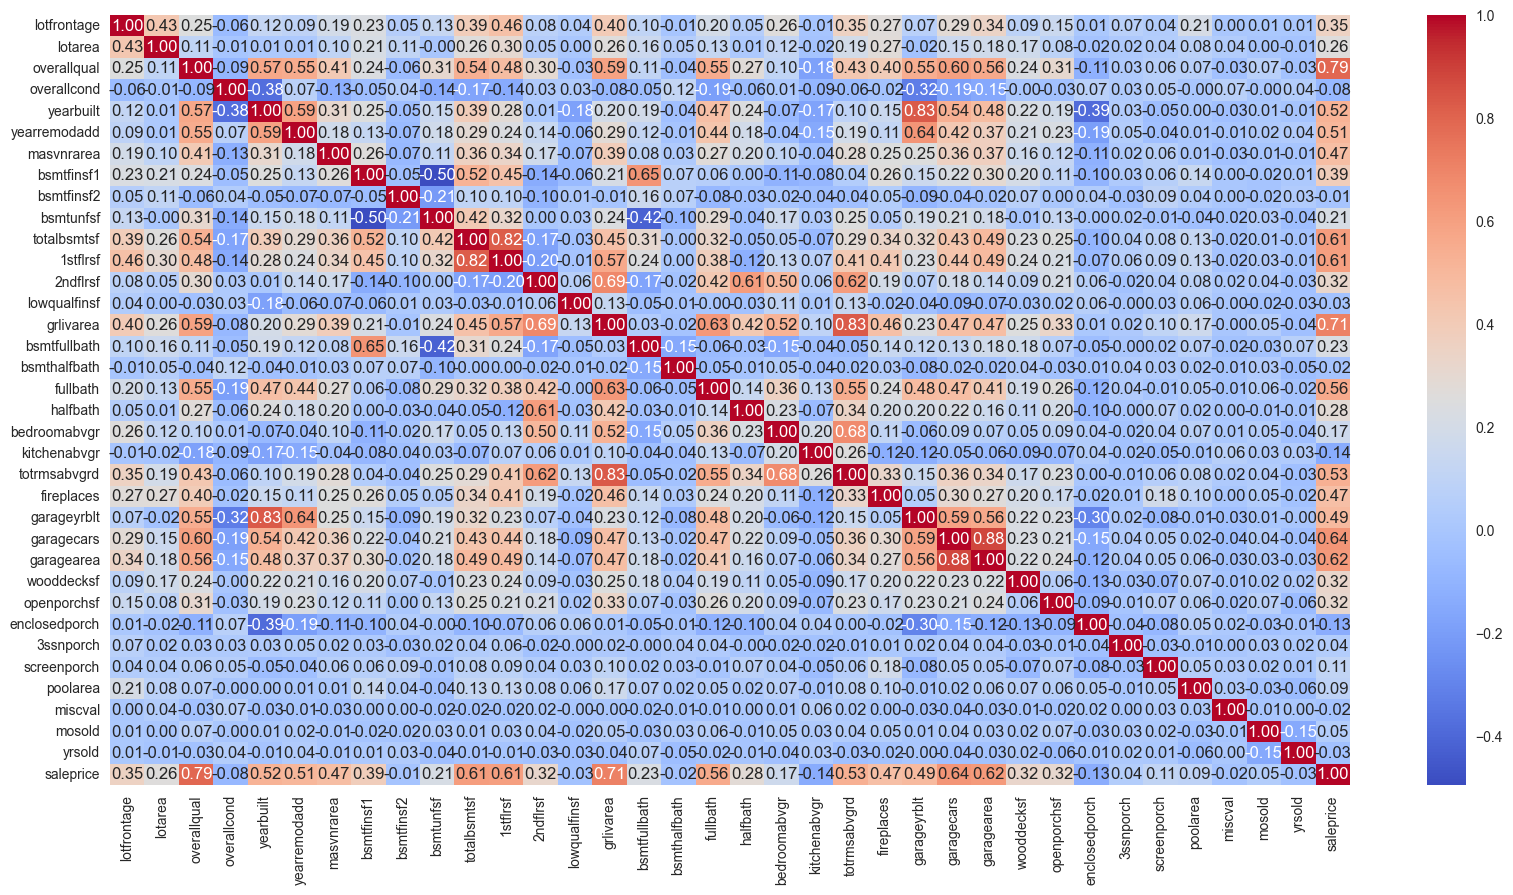

Highly correlated pair: overallqual & saleprice (Correlation coefficient: 0.791)
Highly correlated pair: yearbuilt & garageyrblt (Correlation coefficient: 0.826)
Highly correlated pair: totalbsmtsf & 1stflrsf (Correlation coefficient: 0.82)
Highly correlated pair: grlivarea & totrmsabvgrd (Correlation coefficient: 0.825)
Highly correlated pair: garagecars & garagearea (Correlation coefficient: 0.882)


In [41]:
# Correlation matrix of train set with "id" excluded. Checking for multicollinearity
corr_matrix = train0.drop(columns= ["id"]).corr(numeric_only=True)
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True , cmap="coolwarm", fmt=".2f")
plt.show()

threshold = 0.75
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i,j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i,j]))
            
for pair in high_corr_pairs:
    print(f"Highly correlated pair: {pair[0]} & {pair[1]} (Correlation coefficient: {pair[2].round(3)})")

### Test Set <a class="anchor" id="section5.3.2"></a>

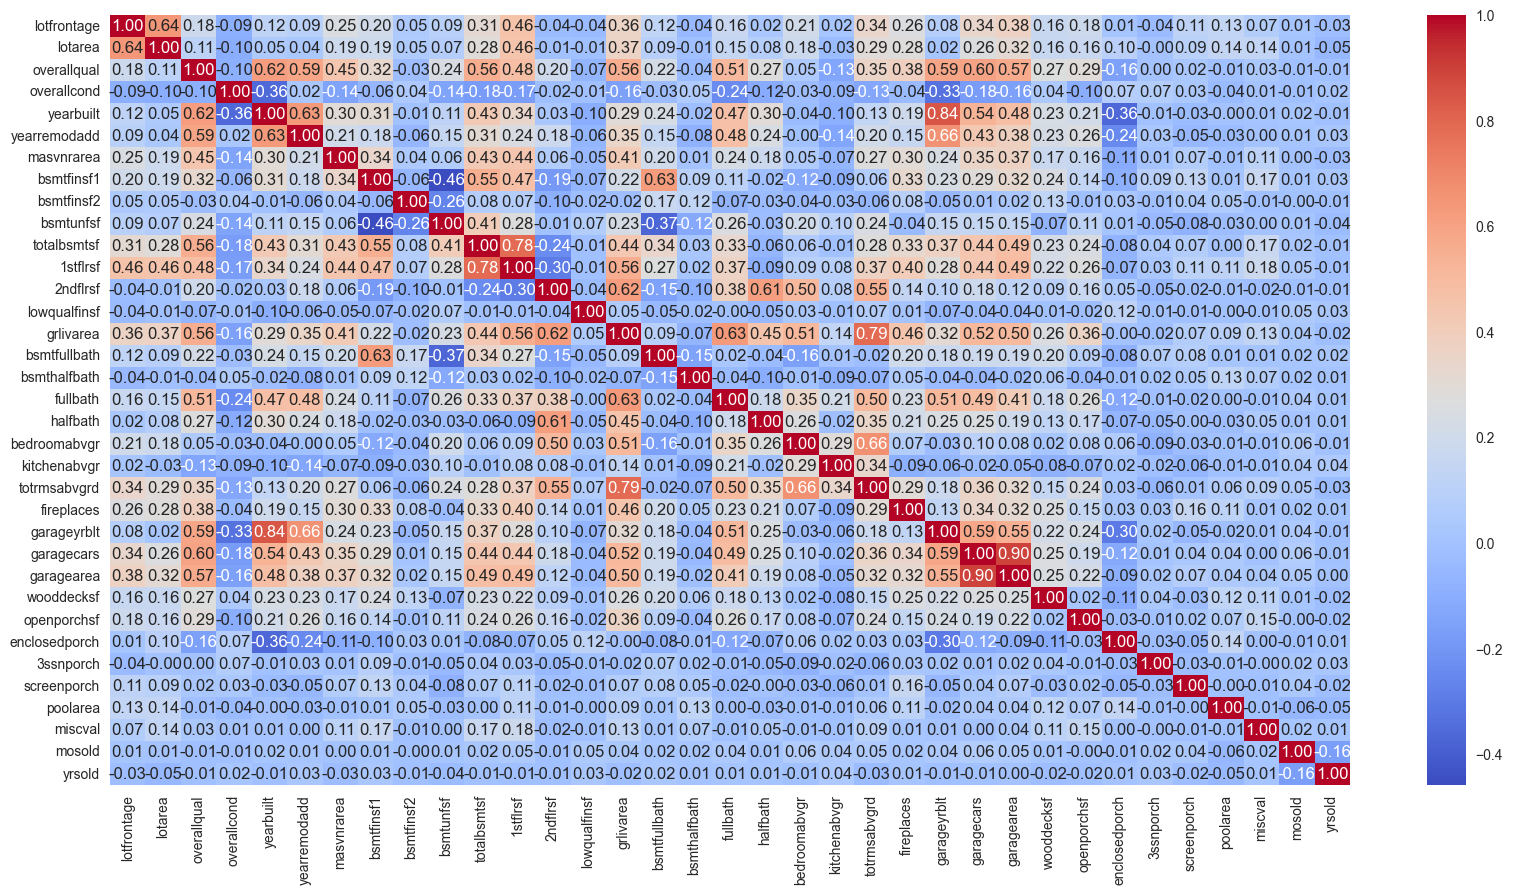

Highly correlated pair: yearbuilt & garageyrblt (Correlation coefficient: 0.844)
Highly correlated pair: totalbsmtsf & 1stflrsf (Correlation coefficient: 0.784)
Highly correlated pair: grlivarea & totrmsabvgrd (Correlation coefficient: 0.788)
Highly correlated pair: garagecars & garagearea (Correlation coefficient: 0.897)


In [42]:
# Correlation matrix of test set checking for multicollinearity in relation to the train set
corr_matrix = test0.drop(columns= ["id"]).corr(numeric_only=True)
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True , cmap="coolwarm", fmt=".2f")
plt.show()

threshold = 0.75
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i,j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i,j]))
            
for pair in high_corr_pairs:
    print(f"Highly correlated pair: {pair[0]} & {pair[1]} (Correlation coefficient: {pair[2].round(3)})")

In [43]:
train0 = train0.drop(columns= ["garageyrblt", "lotfrontage", "garagecars", "totrmsabvgrd", "totalbsmtsf"])

In [44]:
test0 = test0.drop(columns= ["garageyrblt", "lotfrontage", "garagecars", "totrmsabvgrd", "totalbsmtsf"])

In [45]:
## Data used for Exploratoy Analysis. 
# tableau_data = train0.copy()

# tableau_data.to_csv(r"", index=False, header=True)

In [46]:
test0

,id,mssubclass,mszoning,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,functional,fireplaces,fireplacequ,garagetype,garagefinish,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
0,1461,60,RH,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,Typ,0,None,Attchd,Unf,730.0,TA,TA,Y,140,0,0,0,120,0,None,MnPrv,None,0,6,2010,WD,Normal
1,1462,20,RL,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,Typ,0,None,Attchd,Unf,312.0,TA,TA,Y,393,36,0,0,0,0,None,None,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,Typ,1,TA,Attchd,Fin,482.0,TA,TA,Y,212,34,0,0,0,0,None,MnPrv,None,0,3,2010,WD,Normal
3,1464,70,RL,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,Typ,1,Gd,Attchd,Fin,470.0,TA,TA,Y,360,36,0,0,0,0,None,None,None,0,6,2010,WD,Normal
4,1465,60,RL,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,Typ,0,None,Attchd,RFn,506.0,TA,TA,Y,0,82,0,0,144,0,None,None,None,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,20,RM,1936,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,Typ,0,None,None,None,0.0,None,None,Y,0,0,0,0,0,0,None,None,None,0,6,2006,WD,Normal
1455,2916,60,RM,1894,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,Typ,0,None,CarPort,Unf,286.0,TA,TA,Y,0,24,0,0,0,0,None,None,None,0,4,2006,WD,Abnorml
1456,2917,20,RL,20000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,Typ,1,TA,Detchd,Unf,576.0,TA,TA,Y,474,0,0,0,0,0,None,None,None,0,9,2006,WD,Abnorml
1457,2918,70,RL,10441,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,Typ,0,None,None,None,0.0,None,None,Y,80,32,0,0,0,0,None,MnPrv,Shed,700,7,2006,WD,Normal


# Exploratory Data Analysis <a class="anchor" id="section6"></a>
The decision was made to delegate this stage of the process to Tableau Public for its cleaner and more interactive output. Since this notebook is already fairly long, the EDA can be found [here](https://public.tableau.com/views/ResidentialHomes-AmesIowa/pricemosold?:language=en-US&:sid=&:display_count=n&:origin=viz_share_link).

# Transformations <a class="anchor" id="section7"></a>
In this section, it was decided to combine the Train and Test Sets to ensure uniformity between the two datasets. Efforts were made to avoid data leakage and to ensure precise and simple separation of the datasets. Since there are a vast number of zero feature values in this dataset and applying a log transformation to those values would result in undefined values, the equation log(1 + x) was used. Log transformations were applied to the features that were considered skewd in absolute terms, with a threshold value of greater than or equal to 0.5. 

The `mosold` feature is excluded from the log transformation not only because its skewness values was lower than 0.5 but also because of seasonality; the numbers have a deeper meaning, representing months of the year rather than just a ranking or some other metric. For example, months 1 and 12 may have similar temperatures, but a machine learning model may not be able to make that distinction. To account for this, a cosine transformation was applied to the `mosold` feature. 

The `saleprice` target feature was kept separate from the other numerical features bacause when combining the two datasets, `saleprice` doesn't exist in the Test Set, as it is the metric being predicted. Below, a graph of the distribution of the `saleprice` can be found, depicting the skewness of the feature and a need for a transformation. A normal log transformation was applied to this feature due to the absence of zero values for `saleprice`. 

## Normailty - Log Transformation <a class="anchor" id="section7.1"></a>

In [47]:
target_og = train0.saleprice
train1 = train0.drop(["id", "saleprice"], axis=1).copy()

test_ids = test0.id
test1 = test0.drop("id", axis=1)

# Ensure to not mix the data in the process.
train1["is_train"] = 1
test1["is_train"] = 0

combo0 = pd.concat([train1,test1], axis=0).reset_index(drop=True)
combo1 = combo0.copy()

num_df = combo1.select_dtypes(np.number)
num_df

,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,fireplaces,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,is_train
0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856,854,0,1710,1.0,0.0,2,1,3,1,0,548.0,0,61,0,0,0,0,0,2,2008,1
1,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262,0,0,1262,0.0,1.0,2,0,3,1,1,460.0,298,0,0,0,0,0,0,5,2007,1
2,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920,866,0,1786,1.0,0.0,2,1,3,1,1,608.0,0,42,0,0,0,0,0,9,2008,1
3,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,961,756,0,1717,1.0,0.0,1,0,3,1,1,642.0,0,35,272,0,0,0,0,2,2006,1
4,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,1,836.0,192,84,0,0,0,0,0,12,2008,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,1936,4,7,1970,1970,0.0,0.0,0.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,0,0.0,0,0,0,0,0,0,0,6,2006,0
2915,1894,4,5,1970,1970,0.0,252.0,0.0,294.0,546,546,0,1092,0.0,0.0,1,1,3,1,0,286.0,0,24,0,0,0,0,0,4,2006,0
2916,20000,5,7,1960,1996,0.0,1224.0,0.0,0.0,1224,0,0,1224,1.0,0.0,1,0,4,1,1,576.0,474,0,0,0,0,0,0,9,2006,0
2917,10441,5,5,1992,1992,0.0,337.0,0.0,575.0,970,0,0,970,0.0,1.0,1,0,3,1,0,0.0,80,32,0,0,0,0,700,7,2006,0


In [48]:
skew_num = pd.DataFrame(num_df.columns, columns=["feature"])
skew_num["skew"] = skew_num.feature.apply(lambda x: scipy.stats.skew(num_df[x]))
skew_num["absolute_skew"] = skew_num["skew"].apply(abs)
skew_num["skewed"] = skew_num.absolute_skew.apply(lambda x: True if x >= 0.5 else False)

In [49]:
skew_num

,feature,skew,absolute_skew,skewed
0,lotarea,12.822431,12.822431,True
1,overallqual,0.197110,0.197110,False
2,overallcond,0.570312,0.570312,True
3,yearbuilt,-0.599806,0.599806,True
4,yearremodadd,-0.451020,0.451020,False
5,masvnrarea,2.613592,2.613592,True
6,bsmtfinsf1,1.425230,1.425230,True
7,bsmtfinsf2,4.146143,4.146143,True
8,bsmtunfsf,0.919339,0.919339,True
9,1stflrsf,1.469604,1.469604,True


In [50]:
# Zero = undefined
for c in skew_num.query("skewed == True").feature.values:
    combo1[c] = np.log1p(combo1[c])

In [51]:
combo1

,mssubclass,mszoning,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,functional,fireplaces,fireplacequ,garagetype,garagefinish,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,is_train
0,60,RL,9.042040,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,1.791759,7.602900,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.283204,Gd,TA,PConc,Gd,TA,No,GLQ,6.561031,Unf,0.0,5.017280,GasA,Ex,Y,SBrkr,6.753438,6.751101,0.0,7.444833,0.693147,0.000000,2,0.693147,3,0.693147,Gd,Typ,0.000000,None,Attchd,RFn,548.0,TA,TA,Y,0.000000,4.127134,0.000000,0.0,0.0,0.0,None,None,None,0.000000,2,2008,WD,Normal,1
1,20,RL,9.169623,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,2.197225,7.589336,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,6.886532,Unf,0.0,5.652489,GasA,Ex,Y,SBrkr,7.141245,0.000000,0.0,7.141245,0.000000,0.693147,2,0.000000,3,0.693147,TA,Typ,0.693147,TA,Attchd,RFn,460.0,TA,TA,Y,5.700444,0.000000,0.000000,0.0,0.0,0.0,None,None,None,0.000000,5,2007,WD,Normal,1
2,60,RL,9.328212,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,1.791759,7.601902,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.093750,Gd,TA,PConc,Gd,TA,Mn,GLQ,6.188264,Unf,0.0,6.075346,GasA,Ex,Y,SBrkr,6.825460,6.765039,0.0,7.488294,0.693147,0.000000,2,0.693147,3,0.693147,Gd,Typ,0.693147,TA,Attchd,RFn,608.0,TA,TA,Y,0.000000,3.761200,0.000000,0.0,0.0,0.0,None,None,None,0.000000,9,2008,WD,Normal,1
3,70,RL,9.164401,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,1.791759,7.557995,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,5.379897,Unf,0.0,6.293419,GasA,Gd,Y,SBrkr,6.869014,6.629363,0.0,7.448916,0.693147,0.000000,1,0.000000,3,0.693147,Gd,Typ,0.693147,Gd,Detchd,Unf,642.0,TA,TA,Y,0.000000,3.583519,5.609472,0.0,0.0,0.0,None,None,None,0.000000,2,2006,WD,Abnorml,1
4,60,RL,9.565284,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,1.791759,7.601402,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.860786,Gd,TA,PConc,Gd,TA,Av,GLQ,6.486161,Unf,0.0,6.196444,GasA,Ex,Y,SBrkr,7.044033,6.960348,0.0,7.695758,0.693147,0.000000,2,0.693147,4,0.693147,Gd,Typ,0.693147,TA,Attchd,RFn,836.0,TA,TA,Y,5.262690,4.442651,0.000000,0.0,0.0,0.0,None,None,None,0.000000,12,2008,WD,Normal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,20,RM,7.568896,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,2.079442,7.586296,1970,Gable,CompShg,CemntBd,CmentBd,None,0.000000,TA,TA,CBlock,TA,TA,No,Unf,0.000000,Unf,0.0,6.304449,GasA,Gd,Y,SBrkr,6.304449,6.304449,0.0,6.996681,0.000000,0.000000,1,0.693147,3,0.693147,TA,Typ,0.000000,None,None,None,0.0,None,None,Y,0.000000,0.000000,0.000000,0.0,0.0,0.0,None,None,None,0.000000,6,2006,WD,Normal,0
2915,60,RM,7.546974,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,1.791759,7.586296,1970,Gable,CompShg,CemntBd,CmentBd,None,0.000000,TA,TA,CBlock,TA,TA,No,Rec,5.533389,Unf,0.0,5.686975,GasA,TA,Y,SBrkr,6.304449,6.304449,0.0,6.996681,0.000000,0.000000,1,0.693147,3,0.693147,TA,Typ,0.000000,None,CarPort,Unf,286.0,TA,TA,Y,0.000000,3.218876,0.000000,0.0,0.0,0.0,None,Non

## Seasonality - Cosine Transformation <a class="anchor" id="section7.2"></a>

In [52]:
 # -cos(0.5236x)
print(combo1.mosold.unique())
combo1.mosold = (-np.cos(0.5236 * combo1.mosold))

[ 2  5  9 12 10  8 11  4  1  7  3  6]


In [53]:
combo1

,mssubclass,mszoning,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,functional,fireplaces,fireplacequ,garagetype,garagefinish,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,is_train
0,60,RL,9.042040,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,1.791759,7.602900,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.283204,Gd,TA,PConc,Gd,TA,No,GLQ,6.561031,Unf,0.0,5.017280,GasA,Ex,Y,SBrkr,6.753438,6.751101,0.0,7.444833,0.693147,0.000000,2,0.693147,3,0.693147,Gd,Typ,0.000000,None,Attchd,RFn,548.0,TA,TA,Y,0.000000,4.127134,0.000000,0.0,0.0,0.0,None,None,None,0.000000,-0.499998,2008,WD,Normal,1
1,20,RL,9.169623,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,2.197225,7.589336,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,6.886532,Unf,0.0,5.652489,GasA,Ex,Y,SBrkr,7.141245,0.000000,0.0,7.141245,0.000000,0.693147,2,0.000000,3,0.693147,TA,Typ,0.693147,TA,Attchd,RFn,460.0,TA,TA,Y,5.700444,0.000000,0.000000,0.0,0.0,0.0,None,None,None,0.000000,0.866028,2007,WD,Normal,1
2,60,RL,9.328212,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,1.791759,7.601902,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.093750,Gd,TA,PConc,Gd,TA,Mn,GLQ,6.188264,Unf,0.0,6.075346,GasA,Ex,Y,SBrkr,6.825460,6.765039,0.0,7.488294,0.693147,0.000000,2,0.693147,3,0.693147,Gd,Typ,0.693147,TA,Attchd,RFn,608.0,TA,TA,Y,0.000000,3.761200,0.000000,0.0,0.0,0.0,None,None,None,0.000000,-0.000011,2008,WD,Normal,1
3,70,RL,9.164401,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,1.791759,7.557995,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,5.379897,Unf,0.0,6.293419,GasA,Gd,Y,SBrkr,6.869014,6.629363,0.0,7.448916,0.693147,0.000000,1,0.000000,3,0.693147,Gd,Typ,0.693147,Gd,Detchd,Unf,642.0,TA,TA,Y,0.000000,3.583519,5.609472,0.0,0.0,0.0,None,None,None,0.000000,-0.499998,2006,WD,Abnorml,1
4,60,RL,9.565284,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,1.791759,7.601402,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.860786,Gd,TA,PConc,Gd,TA,Av,GLQ,6.486161,Unf,0.0,6.196444,GasA,Ex,Y,SBrkr,7.044033,6.960348,0.0,7.695758,0.693147,0.000000,2,0.693147,4,0.693147,Gd,Typ,0.693147,TA,Attchd,RFn,836.0,TA,TA,Y,5.262690,4.442651,0.000000,0.0,0.0,0.0,None,None,None,0.000000,-1.000000,2008,WD,Normal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,20,RM,7.568896,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,2.079442,7.586296,1970,Gable,CompShg,CemntBd,CmentBd,None,0.000000,TA,TA,CBlock,TA,TA,No,Unf,0.000000,Unf,0.0,6.304449,GasA,Gd,Y,SBrkr,6.304449,6.304449,0.0,6.996681,0.000000,0.000000,1,0.693147,3,0.693147,TA,Typ,0.000000,None,None,None,0.0,None,None,Y,0.000000,0.000000,0.000000,0.0,0.0,0.0,None,None,None,0.000000,1.000000,2006,WD,Normal,0
2915,60,RM,7.546974,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,1.791759,7.586296,1970,Gable,CompShg,CemntBd,CmentBd,None,0.000000,TA,TA,CBlock,TA,TA,No,Rec,5.533389,Unf,0.0,5.686975,GasA,TA,Y,SBrkr,6.304449,6.304449,0.0,6.996681,0.000000,0.000000,1,0.693147,3,0.693147,TA,Typ,0.000000,None,CarPort,Unf,286.0,TA,TA,Y,0.

## Target Transformation <a class="anchor" id="section7.3"></a>

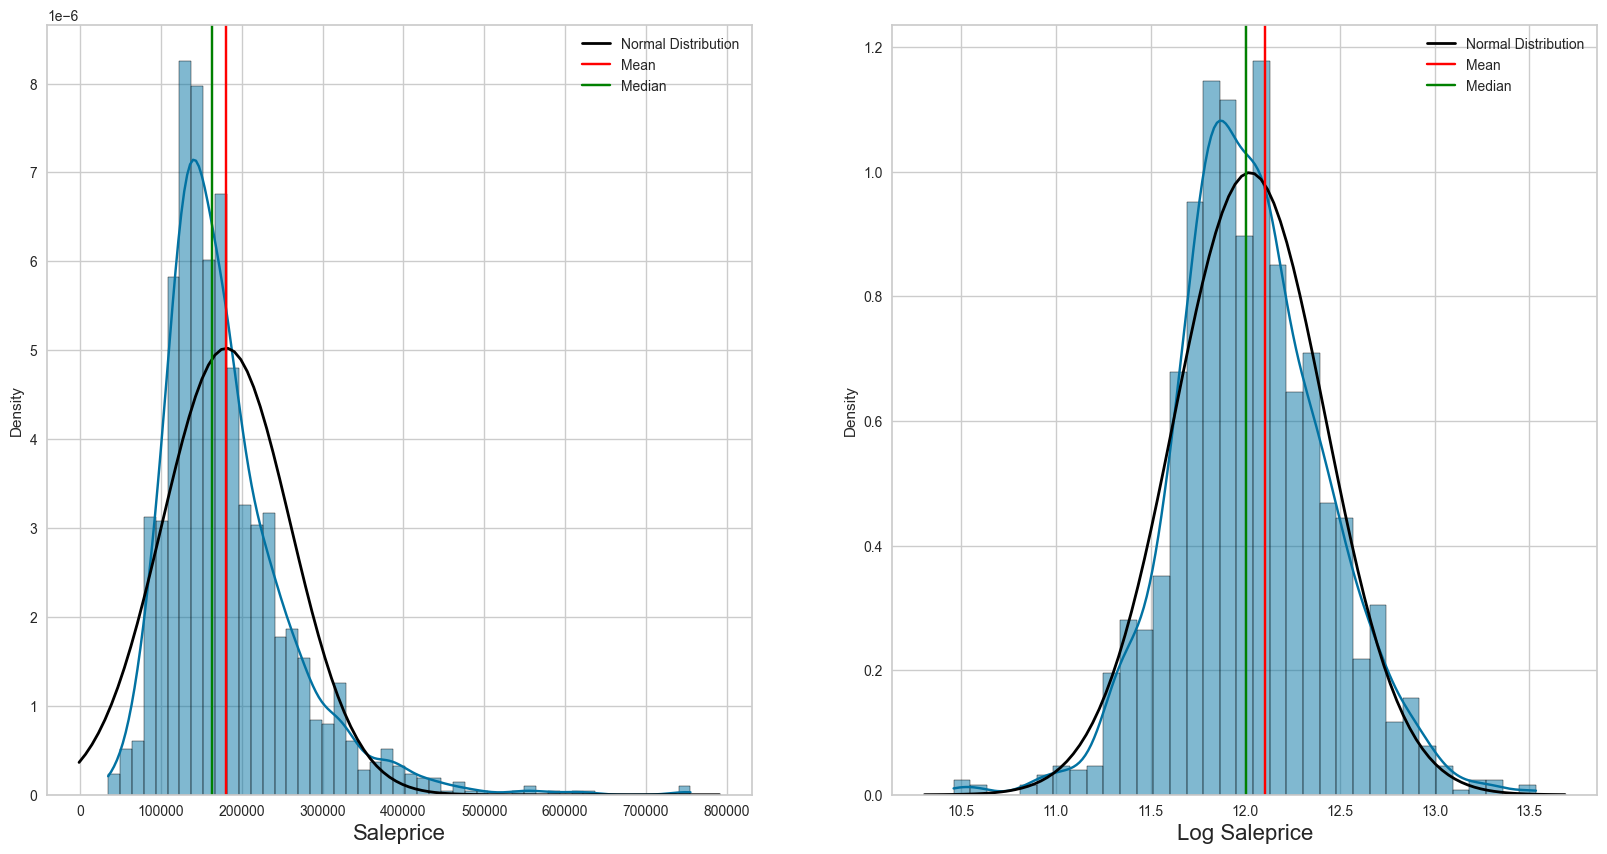

In [54]:
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.histplot(target_og, kde=True, stat="density")
mu, std = scipy.stats.norm.fit(target_og)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
plt.plot(x, p, linewidth=2, c="black", label="Normal Distribution")
plt.axvline(np.mean(target_og), c="red", label="Mean")
plt.axvline(np.median(target_og), c="green", label="Median")
plt.xlabel("Saleprice",fontsize=16)
plt.legend()


plt.subplot(122)
sns.histplot(np.log(target_og), kde=True, stat="density")
mu, std = scipy.stats.norm.fit(np.log(target_og))
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
plt.plot(x, p, linewidth=2, c="black", label="Normal Distribution")
plt.axvline(np.log(np.mean(target_og)), c="red", label="Mean")
plt.axvline(np.log(np.median(target_og)), c="green", label="Median")
plt.xlabel("Log Saleprice", fontsize=16)
plt.legend()
plt.show()

In [55]:
target_log = np.log(target_og)
target_log

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: saleprice, Length: 1460, dtype: float64

# Encoding Data <a class="anchor" id="section8"></a>
Regarding the ordinal values, the dataset is missing categories compared to the values in the [data documentation](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data). To account for this, a "dummy" row is placed at the end of the combined dataset with the missing values so the features can be encoded correctly. Removal of this "dummy" row is made at the end of this process to avoid compromising the data. For the categorical values, One Hot Encoding is applied to ensure compatibility with the regression algorithms. 

Additionally, there are two versions of encoding on the dataset: one with more ordinal features (v1) and one with fewer (v2). For curiosity's sake, these were the features in question: `centralair`, `electrical`, `functional`, `paveddrive`, `fence`. The reason behind this is basically an assumption. For example, one could think that between two identical homes, one with central air and the other without, the sale price would be higher for the home with central air. 

Furthermore, there are four "Final" versions of the Train Set. One includes the log-transformed `saleprice` target feature, paired with (v1) and another paired with (v2). The other two "Final" versions of the Train Set include the unaltered `saleprice` target feature, also paired with (v1) and (v2). 

## Ordinal Values <a class="anchor" id="section8.1"></a>

In [56]:
# Account for the missing categories by adding a "dummy" row
placeholder_row = pd.Series([25]*len(combo1.columns), index= combo1.columns)
new_index = len(combo1)
combo1.loc[new_index] = placeholder_row
#combo1

In [57]:
# Copy for Version 2 with less ordinal categories (curiosity)
combo1_v2 = combo1.copy()
#combo1_v2

In [58]:
# Version 1
combo1.loc[new_index, "exterqual"] = "Po"
combo1.loc[new_index, "extercond"] = "Po"
combo1.loc[new_index, "bsmtqual"] = "Po"
combo1.loc[new_index, "bsmtcond"] = "Ex" 
combo1.loc[new_index, "bsmtexposure"] = "None" 
combo1.loc[new_index, "bsmtfintype1"] = "None" 
combo1.loc[new_index, "bsmtfintype2"] = "None" 
combo1.loc[new_index, "heatingqc"] = "Ex" 
combo1.loc[new_index, "centralair"] = "Y" 
combo1.loc[new_index, "electrical"] = "FuseA" 
combo1.loc[new_index, "kitchenqual"] = "Po" 
combo1.loc[new_index, "functional"] = "Sal"
combo1.loc[new_index, "fireplacequ"] = "Ex" 
combo1.loc[new_index, "garagefinish"] = "None" 
combo1.loc[new_index, "garagequal"] = "None" 
combo1.loc[new_index, "garagecond"] = "None" 
combo1.loc[new_index, "paveddrive"] = "Y" 
combo1.loc[new_index, "poolqc"] = "TA" 
combo1.loc[new_index, "fence"] = "None" 
#combo1

In [59]:
# For comparison 
combo2 = combo1.copy()

# Dictionary of preferred order of Ordinal Features from documentation
feat_order = {
    "exterqual": ["Ex", "Gd", "TA", "Fa", "Po"],
    "extercond": ["Ex", "Gd", "TA", "Fa", "Po"],
    "bsmtqual": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    "bsmtcond": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    "bsmtexposure": ["Gd", "Av", "Mn", "No", "None"],
    "bsmtfintype1": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "None"],
    "bsmtfintype2": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "None"],
    "heatingqc": ["Ex", "Gd", "TA", "Fa", "Po"],
    "centralair": ["Y", "N"],
    "electrical": ["SBrkr", "FuseA", "FuseF", "FuseP", "Mix"],
    "kitchenqual": ["Ex", "Gd", "TA", "Fa", "Po"],
    "functional": ["Typ", "Min1", "Min2", "Mod", "Maj1", "Maj2", "Sev", "Sal"],
    "fireplacequ": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    "garagefinish": ["Fin", "RFn", "Unf", "None"],
    "garagequal": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    "garagecond": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    "paveddrive": ["Y", "P", "N"],
    "poolqc": ["Ex", "Gd", "TA", "Fa", "None"],
    "fence": ["GdPrv", "MnPrv", "GdWo", "MnWw", "None"]}

feat_order_v2 = {
    "exterqual": ["Ex", "Gd", "TA", "Fa", "Po"],
    "extercond": ["Ex", "Gd", "TA", "Fa", "Po"],
    "bsmtqual": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    "bsmtcond": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    "bsmtexposure": ["Gd", "Av", "Mn", "No", "None"],
    "bsmtfintype1": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "None"],
    "bsmtfintype2": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "None"],
    "heatingqc": ["Ex", "Gd", "TA", "Fa", "Po"],
    "kitchenqual": ["Ex", "Gd", "TA", "Fa", "Po"],
    "fireplacequ": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    "garagefinish": ["Fin", "RFn", "Unf", "None"],
    "garagequal": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    "garagecond": ["Ex", "Gd", "TA", "Fa", "Po", "None"],
    "poolqc": ["Ex", "Gd", "TA", "Fa", "None"],}

ordinal_feats = ["exterqual", "extercond", "bsmtqual", "bsmtcond", "bsmtexposure", "bsmtfintype1", "bsmtfintype2", "heatingqc", 
                 "centralair", "electrical", "kitchenqual", "functional", "fireplacequ", "garagefinish", "garagequal", "garagecond", 
                 "paveddrive", "poolqc", "fence"]
ordinal_feats_v2 = ["exterqual", "extercond", "bsmtqual", "bsmtcond", "bsmtexposure", "bsmtfintype1", "bsmtfintype2", "heatingqc", 
                    "kitchenqual", "fireplacequ","garagefinish", "garagequal", "garagecond", "poolqc"]

In [60]:
for f in ordinal_feats:
    print(f,combo1[f].unique(), combo0[f].unique()) 

exterqual ['Gd' 'TA' 'Ex' 'Fa' 'Po'] ['Gd' 'TA' 'Ex' 'Fa']
extercond ['TA' 'Gd' 'Fa' 'Po' 'Ex'] ['TA' 'Gd' 'Fa' 'Po' 'Ex']
bsmtqual ['Gd' 'TA' 'Ex' 'None' 'Fa' 'Po'] ['Gd' 'TA' 'Ex' 'None' 'Fa']
bsmtcond ['TA' 'Gd' 'None' 'Fa' 'Po' 'Ex'] ['TA' 'Gd' 'None' 'Fa' 'Po']
bsmtexposure ['No' 'Gd' 'Mn' 'Av' 'None'] ['No' 'Gd' 'Mn' 'Av' 'None']
bsmtfintype1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ'] ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
bsmtfintype2 ['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ'] ['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']
heatingqc ['Ex' 'Gd' 'TA' 'Fa' 'Po'] ['Ex' 'Gd' 'TA' 'Fa' 'Po']
centralair ['Y' 'N'] ['Y' 'N']
electrical ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix'] ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix']
kitchenqual ['Gd' 'TA' 'Ex' 'Fa' 'Po'] ['Gd' 'TA' 'Ex' 'Fa']
functional ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev' 'Sal'] ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
fireplacequ ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po'] ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
garagefinish ['R

In [61]:
def generate_mapping(df, features, feat_order):
    mapping_dict = {}
    for f in features:
        unique_feats = list(df[f].unique())
        ordered_feats = [feat for feat in feat_order[f] if feat in unique_feats]
        mapping_dict[f] = {feature: i for i, feature in enumerate(reversed(ordered_feats), start=1)}
    return mapping_dict

mapping_dict = generate_mapping(combo1, ordinal_feats, feat_order)
print(mapping_dict)

for feat, mapping in mapping_dict.items():
    combo1[feat] = combo1[feat].map(mapping)

{'exterqual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}, 'extercond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}, 'bsmtqual': {'None': 1, 'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}, 'bsmtcond': {'None': 1, 'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}, 'bsmtexposure': {'None': 1, 'No': 2, 'Mn': 3, 'Av': 4, 'Gd': 5}, 'bsmtfintype1': {'None': 1, 'Unf': 2, 'LwQ': 3, 'Rec': 4, 'BLQ': 5, 'ALQ': 6, 'GLQ': 7}, 'bsmtfintype2': {'None': 1, 'Unf': 2, 'LwQ': 3, 'Rec': 4, 'BLQ': 5, 'ALQ': 6, 'GLQ': 7}, 'heatingqc': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}, 'centralair': {'N': 1, 'Y': 2}, 'electrical': {'Mix': 1, 'FuseP': 2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5}, 'kitchenqual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}, 'functional': {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}, 'fireplacequ': {'None': 1, 'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}, 'garagefinish': {'None': 1, 'Unf': 2, 'RFn': 3, 'Fin': 4}, 'garagequal': {'None': 1, 'Po': 2, '

In [62]:
for f in ordinal_feats:
    print(f,combo1[f].unique(), combo2[f].unique())

exterqual [4 3 5 2 1] ['Gd' 'TA' 'Ex' 'Fa' 'Po']
extercond [3 4 2 1 5] ['TA' 'Gd' 'Fa' 'Po' 'Ex']
bsmtqual [5 4 6 1 3 2] ['Gd' 'TA' 'Ex' 'None' 'Fa' 'Po']
bsmtcond [4 5 1 3 2 6] ['TA' 'Gd' 'None' 'Fa' 'Po' 'Ex']
bsmtexposure [2 5 3 4 1] ['No' 'Gd' 'Mn' 'Av' 'None']
bsmtfintype1 [7 6 2 4 5 1 3] ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
bsmtfintype2 [2 5 1 6 4 3 7] ['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']
heatingqc [5 4 3 2 1] ['Ex' 'Gd' 'TA' 'Fa' 'Po']
centralair [2 1] ['Y' 'N']
electrical [5 3 4 2 1] ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix']
kitchenqual [4 3 5 2 1] ['Gd' 'TA' 'Ex' 'Fa' 'Po']
functional [8 7 4 6 5 3 2 1] ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev' 'Sal']
fireplacequ [1 4 5 3 6 2] ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
garagefinish [3 2 4 1] ['RFn' 'Unf' 'Fin' 'None']
garagequal [4 3 5 1 6 2] ['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
garagecond [4 3 1 5 2 6] ['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']
paveddrive [3 1 2] ['Y' 'N' 'P']
poolqc [1 5 2 4 3] ['None' 'Ex' 'Fa' 'Gd' 'TA']
fenc

In [63]:
# Version 2 
combo1_v2.loc[new_index, "exterqual"] = "Po"
combo1_v2.loc[new_index, "extercond"] = "Po"
combo1_v2.loc[new_index, "bsmtqual"] = "Po"
combo1_v2.loc[new_index, "bsmtcond"] = "Ex" 
combo1_v2.loc[new_index, "bsmtexposure"] = "None" 
combo1_v2.loc[new_index, "bsmtfintype1"] = "None" 
combo1_v2.loc[new_index, "bsmtfintype2"] = "None" 
combo1_v2.loc[new_index, "heatingqc"] = "Ex" 
combo1_v2.loc[new_index, "centralair"] = "Y" 
combo1_v2.loc[new_index, "electrical"] = "FuseA" 
combo1_v2.loc[new_index, "kitchenqual"] = "Po" 
combo1_v2.loc[new_index, "functional"] = "Sal"
combo1_v2.loc[new_index, "fireplacequ"] = "Ex" 
combo1_v2.loc[new_index, "garagefinish"] = "None" 
combo1_v2.loc[new_index, "garagequal"] = "None" 
combo1_v2.loc[new_index, "garagecond"] = "None" 
combo1_v2.loc[new_index, "paveddrive"] = "Y" 
combo1_v2.loc[new_index, "poolqc"] = "TA" 
combo1_v2.loc[new_index, "fence"] = "None" 
#combo1_v2

In [64]:
for f in ordinal_feats_v2:
    print(f,combo1_v2[f].unique(), combo0[f].unique())

exterqual ['Gd' 'TA' 'Ex' 'Fa' 'Po'] ['Gd' 'TA' 'Ex' 'Fa']
extercond ['TA' 'Gd' 'Fa' 'Po' 'Ex'] ['TA' 'Gd' 'Fa' 'Po' 'Ex']
bsmtqual ['Gd' 'TA' 'Ex' 'None' 'Fa' 'Po'] ['Gd' 'TA' 'Ex' 'None' 'Fa']
bsmtcond ['TA' 'Gd' 'None' 'Fa' 'Po' 'Ex'] ['TA' 'Gd' 'None' 'Fa' 'Po']
bsmtexposure ['No' 'Gd' 'Mn' 'Av' 'None'] ['No' 'Gd' 'Mn' 'Av' 'None']
bsmtfintype1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ'] ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
bsmtfintype2 ['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ'] ['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']
heatingqc ['Ex' 'Gd' 'TA' 'Fa' 'Po'] ['Ex' 'Gd' 'TA' 'Fa' 'Po']
kitchenqual ['Gd' 'TA' 'Ex' 'Fa' 'Po'] ['Gd' 'TA' 'Ex' 'Fa']
fireplacequ ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po'] ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
garagefinish ['RFn' 'Unf' 'Fin' 'None'] ['RFn' 'Unf' 'Fin' 'None']
garagequal ['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po'] ['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
garagecond ['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex'] ['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']
poolqc ['None' 'Ex' 'Fa' '

In [65]:
mapping_dict_v2 = generate_mapping(combo1_v2, ordinal_feats_v2, feat_order_v2)
print(mapping_dict)

for feat, mapping in mapping_dict_v2.items():
    combo1_v2[feat] = combo1_v2[feat].map(mapping)

{'exterqual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}, 'extercond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}, 'bsmtqual': {'None': 1, 'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}, 'bsmtcond': {'None': 1, 'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}, 'bsmtexposure': {'None': 1, 'No': 2, 'Mn': 3, 'Av': 4, 'Gd': 5}, 'bsmtfintype1': {'None': 1, 'Unf': 2, 'LwQ': 3, 'Rec': 4, 'BLQ': 5, 'ALQ': 6, 'GLQ': 7}, 'bsmtfintype2': {'None': 1, 'Unf': 2, 'LwQ': 3, 'Rec': 4, 'BLQ': 5, 'ALQ': 6, 'GLQ': 7}, 'heatingqc': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}, 'centralair': {'N': 1, 'Y': 2}, 'electrical': {'Mix': 1, 'FuseP': 2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5}, 'kitchenqual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}, 'functional': {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}, 'fireplacequ': {'None': 1, 'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6}, 'garagefinish': {'None': 1, 'Unf': 2, 'RFn': 3, 'Fin': 4}, 'garagequal': {'None': 1, 'Po': 2, '

In [66]:
for f in ordinal_feats_v2:
    print(f,combo1_v2[f].unique(), combo2[f].unique())

exterqual [4 3 5 2 1] ['Gd' 'TA' 'Ex' 'Fa' 'Po']
extercond [3 4 2 1 5] ['TA' 'Gd' 'Fa' 'Po' 'Ex']
bsmtqual [5 4 6 1 3 2] ['Gd' 'TA' 'Ex' 'None' 'Fa' 'Po']
bsmtcond [4 5 1 3 2 6] ['TA' 'Gd' 'None' 'Fa' 'Po' 'Ex']
bsmtexposure [2 5 3 4 1] ['No' 'Gd' 'Mn' 'Av' 'None']
bsmtfintype1 [7 6 2 4 5 1 3] ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
bsmtfintype2 [2 5 1 6 4 3 7] ['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']
heatingqc [5 4 3 2 1] ['Ex' 'Gd' 'TA' 'Fa' 'Po']
kitchenqual [4 3 5 2 1] ['Gd' 'TA' 'Ex' 'Fa' 'Po']
fireplacequ [1 4 5 3 6 2] ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
garagefinish [3 2 4 1] ['RFn' 'Unf' 'Fin' 'None']
garagequal [4 3 5 1 6 2] ['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
garagecond [4 3 1 5 2 6] ['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']
poolqc [1 5 2 4 3] ['None' 'Ex' 'Fa' 'Gd' 'TA']


In [67]:
combo1

,mssubclass,mszoning,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,functional,fireplaces,fireplacequ,garagetype,garagefinish,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,is_train
0,60,RL,9.042040,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,1.791759,7.602900,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.283204,4,3,PConc,5,4,2,7,6.561031,2,0.0,5.017280,GasA,5,2,5,6.753438,6.751101,0.0,7.444833,0.693147,0.000000,2,0.693147,3,0.693147,4,8,0.000000,1,Attchd,3,548.0,4,4,3,0.000000,4.127134,0.000000,0.0,0.0,0.0,1,1,None,0.000000,-0.499998,2008,WD,Normal,1
1,20,RL,9.169623,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,2.197225,7.589336,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,3,3,CBlock,5,4,5,6,6.886532,2,0.0,5.652489,GasA,5,2,5,7.141245,0.000000,0.0,7.141245,0.000000,0.693147,2,0.000000,3,0.693147,3,8,0.693147,4,Attchd,3,460.0,4,4,3,5.700444,0.000000,0.000000,0.0,0.0,0.0,1,1,None,0.000000,0.866028,2007,WD,Normal,1
2,60,RL,9.328212,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,1.791759,7.601902,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.093750,4,3,PConc,5,4,3,7,6.188264,2,0.0,6.075346,GasA,5,2,5,6.825460,6.765039,0.0,7.488294,0.693147,0.000000,2,0.693147,3,0.693147,4,8,0.693147,4,Attchd,3,608.0,4,4,3,0.000000,3.761200,0.000000,0.0,0.0,0.0,1,1,None,0.000000,-0.000011,2008,WD,Normal,1
3,70,RL,9.164401,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,1.791759,7.557995,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,3,3,BrkTil,4,5,2,6,5.379897,2,0.0,6.293419,GasA,4,2,5,6.869014,6.629363,0.0,7.448916,0.693147,0.000000,1,0.000000,3,0.693147,4,8,0.693147,5,Detchd,2,642.0,4,4,3,0.000000,3.583519,5.609472,0.0,0.0,0.0,1,1,None,0.000000,-0.499998,2006,WD,Abnorml,1
4,60,RL,9.565284,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,1.791759,7.601402,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.860786,4,3,PConc,5,4,4,7,6.486161,2,0.0,6.196444,GasA,5,2,5,7.044033,6.960348,0.0,7.695758,0.693147,0.000000,2,0.693147,4,0.693147,4,8,0.693147,4,Attchd,3,836.0,4,4,3,5.262690,4.442651,0.000000,0.0,0.0,0.0,1,1,None,0.000000,-1.000000,2008,WD,Normal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,60,RM,7.546974,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,1.791759,7.586296,1970,Gable,CompShg,CemntBd,CmentBd,None,0.000000,3,3,CBlock,4,4,2,4,5.533389,2,0.0,5.686975,GasA,3,2,5,6.304449,6.304449,0.0,6.996681,0.000000,0.000000,1,0.693147,3,0.693147,3,8,0.000000,1,CarPort,2,286.0,4,4,3,0.000000,3.218876,0.000000,0.0,0.0,0.0,1,1,None,0.000000,0.500004,2006,WD,Abnorml,0
2916,20,RL,9.903538,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,2.079442,7.581210,1996,Gable,CompShg,VinylSd,VinylSd,None,0.000000,3,3,CBlock,4,4,2,6,7.110696,2,0.0,0.000000,GasA,5,2,5,7.110696,0.000000,0.0,7.110696,0.693147,0.000000,1,0.000000,4,0.693147,3,8,0.693147,4,Detchd,2,576.0,4,4,3,6.163315,0.000000,0.000000,0.0,0.0,0.0,1,1,None,0.000000,-0.000011,2006,WD,Abnorml,0
2917,70,RL,9.253591,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,1.791759,7.597396,1992,Gab

## Categorical Values <a class="anchor" id="section8.2"></a>

In [68]:
# Categorical Encoding (OneHot)
combo1 = pd.get_dummies(combo1, dtype=int)
combo1_v2 = pd.get_dummies(combo1_v2, dtype=int)

print(combo1.shape)
print(combo1_v2.shape)

(2920, 261)
(2920, 279)


# Scaling Data <a class="anchor" id="section0"></a>
This section of the notebook can be considered a **"Phantom"** section, meaning that it is not used for the final machine learning model for making predictions. More on "why?" will be discussed in the conclusion of this notebook.

In [69]:
# is_train = combo1.is_train
# combo1 = combo1.drop("is_train", axis=1)

# scaler = StandardScaler()
# scaler.fit(combo1)
# combo1 = pd.DataFrame(scaler.transform(combo1), index=combo1.index, columns=combo1.columns)

# combo1 = pd.concat([combo1, is_train], axis=1)

In [70]:
# is_train_v2 = combo1_v2.is_train
# combo1_v2 = combo1_v2.drop("is_train", axis=1)

# scaler_v2 = StandardScaler()
# scaler_v2.fit(combo1_v2)
# combo1_v2 = pd.DataFrame(scaler_v2.transform(combo1_v2), index=combo1_v2.index, columns=combo1_v2.columns)

# combo1_v2 = pd.concat([combo1_v2, is_train_v2], axis=1)

### Remove "dummy" row and Split into Train and Test Sets <a class="anchor" id="section8.3"></a>

In [71]:
combo1 = combo1.drop(2919, axis=0)
combo1_v2 = combo1_v2.drop(2919, axis=0)

In [72]:
combo1

,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,exterqual,extercond,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,functional,fireplaces,fireplacequ,garagefinish,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscval,mosold,yrsold,is_train,mssubclass_25,mssubclass_120,mssubclass_160,mssubclass_180,mssubclass_190,mssubclass_20,mssubclass_30,mssubclass_40,mssubclass_45,mssubclass_50,mssubclass_60,mssubclass_70,mssubclass_75,mssubclass_80,mssubclass_85,mssubclass_90,mszoning_25,mszoning_C (all),mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_25,street_Grvl,street_Pave,alley_25,alley_Grvl,alley_None,alley_Pave,lotshape_25,lotshape_IR1,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_25,landcontour_Bnk,landcontour_HLS,landcontour_Low,landcontour_Lvl,utilities_25,utilities_AllPub,utilities_NoSeWa,lotconfig_25,lotconfig_Corner,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,landslope_25,landslope_Gtl,landslope_Mod,landslope_Sev,neighborhood_25,neighborhood_Blmngtn,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,condition1_25,condition1_Artery,condition1_Feedr,condition1_Norm,condition1_PosA,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,condition1_RRNn,condition2_25,condition2_Artery,condition2_Feedr,condition2_Norm,condition2_PosA,condition2_PosN,condition2_RRAe,condition2_RRAn,condition2_RRNn,bldgtype_25,bldgtype_1Fam,bldgtype_2fmCon,bldgtype_Duplex,bldgtype_Twnhs,bldgtype_TwnhsE,housestyle_25,housestyle_1.5Fin,housestyle_1.5Unf,housestyle_1Story,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,roofstyle_25,roofstyle_Flat,roofstyle_Gable,roofstyle_Gambrel,roofstyle_Hip,roofstyle_Mansard,roofstyle_Shed,roofmatl_25,roofmatl_ClyTile,roofmatl_CompShg,roofmatl_Membran,roofmatl_Metal,roofmatl_Roll,roofmatl_Tar&Grv,roofmatl_WdShake,roofmatl_WdShngl,exterior1st_25,exterior1st_AsbShng,exterior1st_AsphShn,exterior1st_BrkComm,exterior1st_BrkFace,exterior1st_CBlock,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_ImStucc,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_Stone,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,exterior2nd_25,exterior2nd_AsbShng,exterior2nd_AsphShn,exterior2nd_Brk Cmn,exterior2nd_BrkFace,exterior2nd_CBlock,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Other,exterior2nd_Plywood,exterior2nd_Stone,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,masvnrtype_25,masvnrtype_BrkCmn,masvnrtype_BrkFace,masvnrtype_None,masvnrtype_Stone,foundation_25,foundation_BrkTil,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,heating_25,heating_Floor,heating_GasA,heating_GasW,heating_Grav,heating_OthW,heating_Wall,garagetype_25,garagetype_2Types,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagetype_None,miscfeature_25,miscfeature_Gar2,miscfeature_None,miscfeature_Othr,miscfeature_Shed,miscfeature_TenC,saletype_25,saletype_COD,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_25,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,sale

In [73]:
# train and test version 2 have less ordinal encoded features than version 1
train2 = combo1[combo1.is_train == 1]
train2_v2 = combo1_v2[combo1_v2.is_train == 1]

test2 = combo1[combo1.is_train == 0]
test2_v2 = combo1_v2[combo1_v2.is_train == 0]

train2 = train2.drop("is_train", axis=1)
train2_v2 = train2_v2.drop("is_train", axis=1)

test2 = test2.drop("is_train", axis=1)
test2_v2 = test2_v2.drop("is_train", axis=1)

train_final_log = pd.concat([train2, target_log], axis=1)
train_final_og = pd.concat([train2, target_og], axis=1)
train_final_log_v2 = pd.concat([train2_v2, target_log], axis=1)
train_final_og_v2 = pd.concat([train2_v2, target_og], axis=1)


test_final = test2.copy()
test_final_v2 = test2_v2.copy()

# Model Selection <a class="anchor" id="section9"></a>
This is where the process of deciding which regression models perform the best is carried out. The lines of code are commented out in this instance because the required information has been extracted and can now be used in later sections of this notebook. The decison was made to choose the top 5 best performing models from *pycaret.regression*. Those models were Bayesian Ridge Regression, Gradient Boosting Regressor, Light Gradient Boosting Regressor, Extra Trees Regressor, and Ridge Regression. The metric on which these models are evaluated is [Root Mean Squared Error (RMSE)](https://help.sap.com/docs/SAP_PREDICTIVE_ANALYTICS/41d1a6d4e7574e32b815f1cc87c00f42/5e5198fd4afe4ae5b48fefe0d3161810.html).

Below, several versions of the data were run through the Model Selection process. It was found that the versions where the log of the `saleprice` feature was applied performed better than the unaltered `saleprice` feature. From here on, the best performer is chosen to move on to the next step in trying to get the lowest RMSE. **With this in mind**, the structure of the notebook looks to be jumping from step to step, but in the hopes of keeping the notebook as short as possible, this route was implimented. For example, all versions of the data were run, and it was found that the data that was not scaled performed better than the scaled data. So overall, the (v1) data with the log of the `saleprice` feature without scaling is used in the rest of this notebook. 

## Not Scaled <a class="anchor" id="section9.1"></a>

In [74]:
log_v1_setup = setup(data=train_final_log, target="saleprice")

,Description,Value
0,Session id,3654
1,Target,saleprice
2,Target type,Regression
3,Original data shape,"(1460, 261)"
4,Transformed data shape,"(1460, 261)"
5,Transformed train set shape,"(1021, 261)"
6,Transformed test set shape,"(439, 261)"
7,Numeric features,260
8,Preprocess,True
9,Imputation type,simple


In [75]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.0927,0.0179,0.1330,0.8864,0.0102,0.0077,0.5420
lightgbm,Light Gradient Boosting Machine,0.0949,0.0193,0.1375,0.8786,0.0106,0.0079,0.3190
br,Bayesian Ridge,0.0882,0.0196,0.1362,0.8774,0.0104,0.0073,0.1150
ridge,Ridge Regression,0.0896,0.0197,0.1368,0.8759,0.0104,0.0075,0.0630
et,Extra Trees Regressor,0.0994,0.0200,0.1397,0.8740,0.0108,0.0083,1.9200
lr,Linear Regression,0.0929,0.0222,0.1442,0.8598,0.0110,0.0078,1.1360
rf,Random Forest Regressor,0.1035,0.0225,0.1486,0.8594,0.0114,0.0086,1.8500
omp,Orthogonal Matching Pursuit,0.1021,0.0244,0.1526,0.8486,0.0117,0.0085,0.0690
ada,AdaBoost Regressor,0.1259,0.0277,0.1654,0.8250,0.0127,0.0105,0.6400
huber,Huber Regressor,0.1430,0.0358,0.1873,0.7732,0.0144,0.0119,0.2690


GradientBoostingRegressor(random_state=3654)

In [76]:
#log_v2_setup = setup(data=train_final_log_v2, target="saleprice")

In [77]:
#compare_models()

In [78]:
#og_v1_setup = setup(data=train_final_og, target="saleprice")

In [79]:
#compare_models()

In [80]:
#og_v2_setup = setup(data=train_final_og_v2, target="saleprice")

In [81]:
#compare_models()

## Scaled <a class="anchor" id="section9.2"></a>
"Phantom" Section

In [82]:
# log_v1_setup_s = setup(data=train_final_log, target="saleprice")

In [83]:
# compare_models()

In [84]:
# log_v2_setup_s = setup(data=train_final_log_v2, target="saleprice")

In [85]:
# compare_models()

# Base Line Model <a class="anchor" id="section10"></a>
To establish a baseline for comparison, the Gradient Boosting Regressor was chosen as it was the best performer out of the top 5 stated above in the Model Selection portion of this notebook. The Train Set was correctly formatted to be fed into the model, and its results are displayed below. This model had a RMSE of **0.13394** on the Test Set.

In [86]:
x = train_final_log.drop("saleprice", axis =1)
y = train_final_log.saleprice

In [164]:
kf = KFold(n_splits=10)
gbr = GradientBoostingRegressor(random_state=133)
gbr.fit(x,y)

GradientBoostingRegressor(random_state=133)

In [165]:
results = cross_val_score(br, x, y, scoring= "neg_mean_squared_error", cv=kf)

In [166]:
gbr_results = -results
gbr_results

array([0.01385838, 0.00950166, 0.0136449 , 0.02330721, 0.02097356,
       0.01080284, 0.01504928, 0.01152763, 0.02813982, 0.01702294])

In [167]:
baseline_gbr_rmse = np.exp(np.sqrt(np.mean(gbr_results)))
log_score = np.sqrt(np.mean(gbr_results))
print("RMSE:",baseline_gbr_rmse)
print("Log RMSE:",log_score)

RMSE: 1.1365477701423456
Log RMSE: 0.12799539610845484


# Hyperparameter Tuning <a class="anchor" id="section11"></a>
Here, *optuna* is used to run through various ranges of values for all models to find the best parameters. Tuning the parameters proved to decrease the RMSE compared to the models run with their default values. *Note* that all models where a random state could be applied was implemented. The code here is commented out due to the computational demand and time it took for this process to finish for some of the models. The results for the hyperparameter tuning were then stored in a dictionary to be used as input for the model parameters for each of the top 5 models. 

## Version 1 - Not Scaled <a class="anchor" id="section11.1"></a>

In [91]:
# def BR_objective(trial):
#     max_iter = trial.suggest_int("max_iter", 150, 600)
#     tol = trial.suggest_loguniform("tol", 1e-8, 10)
#     alpha_1 = trial.suggest_loguniform("alpha_1", 1e-8, 10)
#     alpha_2 = trial.suggest_loguniform("alpha_2", 1e-8, 10)
#     lambda_1 = trial.suggest_loguniform("lambda_1", 1e-8, 10)
#     lambda_2 =trial.suggest_loguniform("lambda_2", 1e-8, 10)
    
#     kf = KFold(n_splits=10)
#     model = BayesianRidge(max_iter=max_iter, tol=tol, alpha_1=alpha_1, alpha_2=alpha_2, lambda_1=lambda_1, lambda_2=lambda_2)
#     model.fit(x,y)
#     cv_scores = np.exp(np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=kf)))
#     mean_score = np.mean(cv_scores)
    
#     return mean_score

In [92]:
# study = optuna.create_study(direction="minimize")
# study.optimize(BR_objective, n_trials=100)

In [93]:
# study.best_params

In [94]:
# def GBR_objective(trial):
#     learning_rate = trial.suggest_float("learning_rate", 0.05, 0.2)
#     n_estimators = trial.suggest_int("n_estimators", 100, 300)
#     max_depth = trial.suggest_int("max_depth", 2, 10)
    
#     kf = KFold(n_splits=10)
#     model = GradientBoostingRegressor(random_state=133, learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
#     model.fit(x,y)
#     cv_scores = np.exp(np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=kf)))
#     mean_score = np.mean(cv_scores)
    
#     return mean_score

In [95]:
# study = optuna.create_study(direction="minimize")
# study.optimize(GBR_objective, n_trials=100)

In [96]:
# study.best_params

In [97]:
# def LGBR_objective(trial):
#     num_leaves = trial.suggest_int("num_leaves", 2,50)
#     learning_rate = trial.suggest_float("learning_rate", 0.05, 0.2)
#     n_estimators = trial.suggest_int("n_estimators", 100, 300)
#     max_depth = trial.suggest_int("max_depth", 2, 10)
    
#     kf = KFold(n_splits=10)
#     model = LGBMRegressor(random_state=133, num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
#     model.fit(x,y)
#     cv_scores = np.exp(np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=kf)))
#     mean_score = np.mean(cv_scores)
    
#     return mean_score

In [98]:
# study = optuna.create_study(direction="minimize")
# study.optimize(LGBR_objective, n_trials=100)

In [99]:
# study.best_params

In [100]:
# def ET_objective(trial):
#     n_estimators = trial.suggest_int("n_estimators", 100, 300)
#     criterion = trial.suggest_categorical("criterion", ["squared_error", "friedman_mse"])
#     max_depth = trial.suggest_int("max_depth", 2, 10)
    
#     kf = KFold(n_splits=10)
#     model = ExtraTreesRegressor(random_state=133, n_estimators=n_estimators, criterion=criterion, max_depth=max_depth)
#     model.fit(x,y)
#     cv_scores = np.exp(np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=kf)))
#     mean_score = np.mean(cv_scores)
    
#     return mean_score

In [101]:
# study = optuna.create_study(direction="minimize")
# study.optimize(ET_objective, n_trials=100)

In [102]:
# study.best_params

In [103]:
# def Ridge_objective(trial):
#     alpha = trial.suggest_int("alpha", 1, 1000)
    
#     kf = KFold(n_splits=10)
#     model = Ridge(random_state=133, alpha=alpha)
#     model.fit(x,y)
#     cv_scores = np.exp(np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=kf)))
#     mean_score = np.mean(cv_scores)
    
#     return mean_score

In [104]:
# study = optuna.create_study(direction="minimize")
# study.optimize(Ridge_objective, n_trials=100)

In [105]:
# study.best_params

In [106]:
# Version 1 log target, not scaled 
br_params = {'max_iter': 247, 'tol': 0.012865417985270017, 'alpha_1': 0.06286275455465637, 'alpha_2': 1.682777647343245, 
             'lambda_1': 1.2288557408644392e-06, 'lambda_2': 0.0006932085830314173}

gbr_params = {'learning_rate': 0.14409867582925995, 'n_estimators': 289, 'max_depth': 3}

lgbr_params = {'num_leaves': 24, 'learning_rate': 0.14973402043458775, 'n_estimators': 145, 'max_depth': 3}

et_params = {'n_estimators': 293, 'criterion': 'friedman_mse', 'max_depth': 10}

ridge_params = {'alpha': 5}

## Version 1 - Scaled <a class="anchor" id="section11.2"></a>
"Phantom" Section

In [107]:
# def GBR_objective(trial):
#     learning_rate = trial.suggest_float("learning_rate", 0.05, 0.2)
#     n_estimators = trial.suggest_int("n_estimators", 100, 300)
#     max_depth = trial.suggest_int("max_depth", 2, 10)
    
#     kf = KFold(n_splits=10)
#     model = GradientBoostingRegressor(random_state=133, learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
#     model.fit(x,y)
#     cv_scores = np.exp(np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=kf)))
#     mean_score = np.mean(cv_scores)
    
#     return mean_score

In [108]:
# study = optuna.create_study(direction="minimize")
# study.optimize(GBR_objective, n_trials=100)

In [109]:
# study.best_params

In [110]:
# def BR_objective(trial):
#     max_iter = trial.suggest_int("max_iter", 150, 600)
#     tol = trial.suggest_loguniform("tol", 1e-8, 10)
#     alpha_1 = trial.suggest_loguniform("alpha_1", 1e-8, 10)
#     alpha_2 = trial.suggest_loguniform("alpha_2", 1e-8, 10)
#     lambda_1 = trial.suggest_loguniform("lambda_1", 1e-8, 10)
#     lambda_2 =trial.suggest_loguniform("lambda_2", 1e-8, 10)
    
#     kf = KFold(n_splits=10)
#     model = BayesianRidge(max_iter=max_iter, tol=tol, alpha_1=alpha_1, alpha_2=alpha_2, lambda_1=lambda_1, lambda_2=lambda_2)
#     model.fit(x,y)
#     cv_scores = np.exp(np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=kf)))
#     mean_score = np.mean(cv_scores)
    
#     return mean_score

In [111]:
# study = optuna.create_study(direction="minimize")
# study.optimize(BR_objective, n_trials=100)

In [112]:
# study.best_params

In [113]:
# def LGBR_objective(trial):
#     num_leaves = trial.suggest_int("num_leaves", 2,50)
#     learning_rate = trial.suggest_float("learning_rate", 0.05, 0.2)
#     n_estimators = trial.suggest_int("n_estimators", 100, 300)
#     max_depth = trial.suggest_int("max_depth", 2, 10)
    
#     kf = KFold(n_splits=10)
#     model = LGBMRegressor(random_state=133, num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
#     model.fit(x,y)
#     cv_scores = np.exp(np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=kf)))
#     mean_score = np.mean(cv_scores)
    
#     return mean_score

In [114]:
# study = optuna.create_study(direction="minimize")
# study.optimize(LGBR_objective, n_trials=100)

In [115]:
# study.best_params

In [116]:
# def OMP_objective(trial):
#     n_nonzero_coefs = trial.suggest_int("n_nonzero_coefs", 1, 28)
#     tol = trial.suggest_loguniform("tol", 1e-8, 1e-3)

    
#     kf = KFold(n_splits=10)
#     model = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs, tol=tol)
#     model.fit(x,y)
#     cv_scores = np.exp(np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=kf)))
#     mean_score = np.mean(cv_scores)
    
#     return mean_score

In [117]:
# study = optuna.create_study(direction="minimize")
# study.optimize(OMP_objective, n_trials=100)

In [118]:
# study.best_params

In [119]:
# def Ridge_objective(trial):
#     alpha = trial.suggest_int("alpha", 1, 1000)
    
#     kf = KFold(n_splits=10)
#     model = Ridge(random_state=133, alpha=alpha)
#     model.fit(x,y)
#     cv_scores = np.exp(np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=kf)))
#     mean_score = np.mean(cv_scores)
    
#     return mean_score

In [120]:
# study = optuna.create_study(direction="minimize")
# study.optimize(Ridge_objective, n_trials=100)

In [121]:
# study.best_params

In [122]:
# # Version 1 log target, scaled
# gbr_params = {'learning_rate': 0.1203288066589501, 'n_estimators': 262, 'max_depth': 3}

# br_params = {'max_iter': 483, 'tol': 0.520443137699357, 'alpha_1': 1.677382285319078e-06, 'alpha_2': 9.402051068414137, 'lambda_1': 0.0008280136610396232, 
#              'lambda_2': 5.650537938186383e-06}

# lgbr_params = {'num_leaves': 29, 'learning_rate': 0.07944808762133479, 'n_estimators': 291, 'max_depth': 3}

# omp_params = {'n_nonzero_coefs': 4, 'tol': 3.502595075904138e-05}

# ridge_params = {'alpha': 129}

# Ensemble <a class="anchor" id="section12"></a>
Here, all the models are trained, and K-Fold cross validation is implemented to gather results. Then, the results for each model are averaged together to compute a "final" result for each model. Standard deviations for each model and the "Overall" RMSE and STD for all 5 models combined are also provided.

In [157]:
# # Version 1 not Scaled Log Target
# models = {"GBR": GradientBoostingRegressor(random_state=133), "LGBR": LGBMRegressor(random_state=133), "BR": BayesianRidge(), 
#           "ET": ExtraTreesRegressor(random_state=133),"Ridge": Ridge(random_state=133)}

# Version 1 not Scaled Log Target, with hyperparameters
models = {"GBR": GradientBoostingRegressor(random_state=133, **gbr_params), "LGBR": LGBMRegressor(random_state=133, **lgbr_params), 
         "BR": BayesianRidge(**br_params), "ET": ExtraTreesRegressor(random_state=133, **et_params),"Ridge": Ridge(random_state=133, **ridge_params)}

# Version 1 Scaled Log Target, with hyperparameters
# models = {"GBR": GradientBoostingRegressor(random_state=133, **gbr_params), "BR": BayesianRidge(**br_params), 
#           "LGBR": LGBMRegressor(random_state=133, **lgbr_params), "OMP": OrthogonalMatchingPursuit(**omp_params), 
#           "Ridge": Ridge(random_state=133, **ridge_params)}
    
# # Version 2 not Scaled Log Target 
# models = {"BR": BayesianRidge(), "Ridge": Ridge(random_state=133), "LGBR": LGBMRegressor(random_state=133), 
#           "GBR": GradientBoostingRegressor(random_state=133),"LR": LinearRegression()}

# # Version 2 Scaled Log Target 
# models = {"BR": BayesianRidge(), "GBR": GradientBoostingRegressor(random_state=133), "Ridge": Ridge(random_state=133), 
#           "LGBR": LGBMRegressor(random_state=133),"OMP": OrthogonalMatchingPursuit()}

In [158]:
for name,model in models.items():
    model.fit(x,y)
    print(f"{name} is trained")

GBR is trained
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3010
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 154
[LightGBM] [Info] Start training from score 12.024051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

ET is trained
Ridge is trained


In [159]:
results = {}
log_results = {}
kf=KFold(n_splits=10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=kf)))
    log_result = np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=kf))
    results[name] = result
    log_results[name] = log_result

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2912
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 150
[LightGBM] [Info] Start training from score 12.026856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2831
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 150
[LightGBM] [Info] Start training from score 12.027930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2903
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 151
[LightGBM] [Info] Start training from score 12.023667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 149
[LightGBM] [Info] Start training from score 12.023765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2831
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 150
[LightGBM] [Info] Start training from score 12.027930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2823
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 150
[LightGBM] [Info] Start training from score 12.019055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [160]:
results

{'GBR': array([1.12405293, 1.10492963, 1.11341426, 1.15424914, 1.16450409,
        1.11843214, 1.12899451, 1.10256496, 1.11420239, 1.14038638]),
 'LGBR': array([1.12360702, 1.10669606, 1.11081796, 1.16008954, 1.17012805,
        1.12336088, 1.1355746 , 1.10143646, 1.14401997, 1.14009557]),
 'BR': array([1.12516955, 1.10299628, 1.12290986, 1.16656839, 1.15463746,
        1.10883347, 1.12990734, 1.11222599, 1.18235832, 1.14002309]),
 'ET': array([1.1311954 , 1.12797869, 1.14857305, 1.17783741, 1.19586757,
        1.12821221, 1.14297588, 1.13033682, 1.13720378, 1.16066837]),
 'Ridge': array([1.1249815 , 1.10250303, 1.12343383, 1.16523901, 1.15493905,
        1.10912362, 1.13013597, 1.11273628, 1.18264006, 1.13969878])}

In [161]:
log_results

{'GBR': array([0.11694084, 0.09978165, 0.1074312 , 0.14345004, 0.15229532,
        0.11192783, 0.12132742, 0.09763924, 0.10813881, 0.13136714]),
 'LGBR': array([0.11654406, 0.10137906, 0.10509665, 0.14849719, 0.15711319,
        0.11632498, 0.12713878, 0.0966152 , 0.13454835, 0.13111209]),
 'BR': array([0.11793373, 0.09803037, 0.1159234 , 0.15406644, 0.1437864 ,
        0.10330854, 0.12213563, 0.10636341, 0.16751102, 0.13104852]),
 'ET': array([0.12327495, 0.12042726, 0.13852034, 0.16368005, 0.17887192,
        0.12063427, 0.13363528, 0.12251566, 0.12857242, 0.14899602]),
 'Ridge': array([0.11776659, 0.09758308, 0.11638991, 0.15292623, 0.14404757,
        0.10357017, 0.12233795, 0.1068221 , 0.16774928, 0.130764  ])}

In [162]:
all_rmse_vals = []
all_std_vals = []
for name, result in results.items():
    rmse = np.mean(result)
    std = np.std(result)
    print(name)
    print("RMSE:", rmse)
    print("STD:", std, "\n")
    
    all_rmse_vals.append(rmse)
    all_std_vals.append(std)
    
overall_rmse = np.mean(all_rmse_vals)
overall_std = np.mean(all_std_vals)
print("Overall Mean RMSE:",overall_rmse)
print("Overall Mean STD:",overall_std)

GBR
RMSE: 1.1265730421323037
STD: 0.0196087732086783 

LGBR
RMSE: 1.1315826119708112
STD: 0.021522078455196988 

BR
RMSE: 1.1345629747119856
STD: 0.024788404671123948 

ET
RMSE: 1.1480849163339006
STD: 0.022070140882289997 

Ridge
RMSE: 1.1345431122690273
STD: 0.024658970409817734 

Overall Mean RMSE: 1.1350693314836058
Overall Mean STD: 0.022529673525421394


In [154]:
all_rmse_vals_log = []
all_std_vals_log = []
for name, result in log_results.items():
    log_rmse = np.mean(result)
    log_std = np.std(result)
    print(name)
    print("Log RMSE:", log_rmse)
    print("STD:", log_std, "\n")
    
    all_rmse_vals_log.append(log_rmse)
    all_std_vals_log.append(log_std)
    
overall_rmse_log = np.mean(all_rmse_vals_log)
overall_std_log = np.mean(all_std_vals_log)
print("Overall Mean Log RMSE:",overall_rmse_log) 
print("Overall Mean Log STD:",overall_std_log)

GBR
Log RMSE: 0.12475949166704772
STD: 0.019698856508227634 

LGBR
Log RMSE: 0.13062509898783842
STD: 0.01761088076719705 

BR
Log RMSE: 0.12616992337882166
STD: 0.021540006024663147 

ET
Log RMSE: 0.1349553566435186
STD: 0.01845895075409572 

Ridge
Log RMSE: 0.12795872628582178
STD: 0.020671563589846034 

Overall Mean Log RMSE: 0.12889371939260963
Overall Mean Log STD: 0.01959605152880592


# Submissions <a class="anchor" id="section13"></a>
Below are all the different versions of the models that were tried before realizing which one performed the best for this project. As noted earlier in the notebook, (v1) with a log target and without scaling had performed the best among all the other models that were tested (RMSE: **0.12428**) . In an attempt to further improve the best performer to this point, custom weights were applied to each of the models in the ensemble based on their individual performance. Doing this lowered the RMSE to **0.12339** 
<br>
<br>
All RMSE "scores" are provided for the various combinations that were tested throughout this project. For example, they can be found here at the end of the code: 
```Python
#baseline_pred = np.exp(models["GBR"].predict(test_final))
#baseline_submission = pd.concat([test_ids, pd.Series(baseline_pred, name="saleprice")], axis=1) # Score: 0.13394
```

## Version 1 - Not Scaled <a class="anchor" id="section13.1"></a>
(log target, more ordinal features)

In [155]:
# baseline_pred = np.exp(models["GBR"].predict(test_final))
# baseline_submission = pd.concat([test_ids, pd.Series(baseline_pred, name="saleprice")], axis=1) # Score: 0.13394

In [156]:
# baseline_submission.to_csv(r"C:\/baseline_submission.csv",
#                           index=False, header=True)

In [132]:
# Equal weighting
# bagged_pred = (0.2 * np.exp(models["BR"].predict(test_final)) + 0.2 * np.exp(models["GBR"].predict(test_final))
#               + 0.2 * np.exp(models["Ridge"].predict(test_final)) + 0.2 * np.exp(models["LGBR"].predict(test_final))
#               + 0.2 * np.exp(models["ET"].predict(test_final)))
# bagged_submission = pd.concat([test_ids, pd.Series(bagged_pred, name="saleprice")], axis=1) # Score: 0.12525

In [133]:
# bagged_submission.to_csv(r"C:\/bagged_submission.csv",
#                           index=False, header=True)

In [134]:
# # Custom weighting
# bagged_pred2 = (0.2 * np.exp(models["BR"].predict(test_final)) + 0.4 * np.exp(models["GBR"].predict(test_final))
#               + 0.2 * np.exp(models["Ridge"].predict(test_final)) + 0.1 * np.exp(models["LGBR"].predict(test_final))
#               + 0.1 * np.exp(models["ET"].predict(test_final)))
# bagged_submission2 = pd.concat([test_ids, pd.Series(bagged_pred2, name="saleprice")], axis=1) # Score: 0.12550

In [135]:
# bagged_submission2.to_csv(r"C:\/bagged_submission2_CW.csv",
#                           index=False, header=True)

In [136]:
# # Equal weighting with hyperparameters
# bagged_pred3 = (0.2 * np.exp(models["BR"].predict(test_final)) + 0.2 * np.exp(models["GBR"].predict(test_final))
#               + 0.2 * np.exp(models["Ridge"].predict(test_final)) + 0.2 * np.exp(models["LGBR"].predict(test_final))
#               + 0.2 * np.exp(models["ET"].predict(test_final)))
# bagged_submission3 = pd.concat([test_ids, pd.Series(bagged_pred3, name="saleprice")], axis=1) # Score: 0.12428

In [137]:
# bagged_submission3.to_csv(r"C:\/bagged_submission3_hyp.csv",
#                           index=False, header=True)

In [138]:
# # Custom weighting with hyperparameters
# bagged_pred4 = (0.2 * np.exp(models["BR"].predict(test_final)) + 0.3 * np.exp(models["GBR"].predict(test_final))
#               + 0.2 * np.exp(models["Ridge"].predict(test_final)) + 0.2 * np.exp(models["LGBR"].predict(test_final))
#               + 0.1 * np.exp(models["ET"].predict(test_final)))
# bagged_submission4 = pd.concat([test_ids, pd.Series(bagged_pred4, name="saleprice")], axis=1) # Score: 0.12348

In [139]:
# bagged_submission4.to_csv(r"C:\/bagged_submission4_hyp_CW.csv",
#                           index=False, header=True)

In [140]:
# Custom weighting 2 with hyperparameters
bagged_pred5 = (0.2 * np.exp(models["BR"].predict(test_final)) + 0.35 * np.exp(models["GBR"].predict(test_final))
              + 0.2 * np.exp(models["Ridge"].predict(test_final)) + 0.2 * np.exp(models["LGBR"].predict(test_final))
              + 0.05 * np.exp(models["ET"].predict(test_final)))
bagged_submission5 = pd.concat([test_ids, pd.Series(bagged_pred5, name="saleprice")], axis=1) # Score: 0.12339

In [141]:
# bagged_submission5.to_csv(r"C:\/bagged_submission5_hyp_CW2.csv",
#                           index=False, header=True)

In [142]:
# # Custom weighting 3 with hyperparameters
# bagged_pred6 = (0.15 * np.exp(models["BR"].predict(test_final)) + 0.4 * np.exp(models["GBR"].predict(test_final))
#               + 0.15 * np.exp(models["Ridge"].predict(test_final)) + 0.25 * np.exp(models["LGBR"].predict(test_final))
#               + 0.05 * np.exp(models["ET"].predict(test_final)))
# bagged_submission6 = pd.concat([test_ids, pd.Series(bagged_pred6, name="saleprice")], axis=1) # Score: 0.12367

In [143]:
# bagged_submission6.to_csv(r"C:\/bagged_submission6_hyp_CW3.csv",
#                           index=False, header=True)

## Version 1 - Scaled <a class="anchor" id="section13.2"></a>
(log target, more ordinal features) "Phantom" Section

In [144]:
# # Equal weighting with hyperparameters
# bagged_pred7 = (0.2 * np.exp(models["BR"].predict(test_final)) + 0.2 * np.exp(models["GBR"].predict(test_final))
#               + 0.2 * np.exp(models["Ridge"].predict(test_final)) + 0.2 * np.exp(models["LGBR"].predict(test_final))
#               + 0.2 * np.exp(models["OMP"].predict(test_final)))
# bagged_submission7 = pd.concat([test_ids, pd.Series(bagged_pred7, name="saleprice")], axis=1) # Score: 0.12844

In [145]:
# bagged_submission7.to_csv(r"C:\/bagged_submission7_hyp_s.csv",
#                           index=False, header=True)

## Version 2 - Not Scaled <a class="anchor" id="section13.3"></a>
(log target, less ordinal features)

In [146]:
# bagged_pred_v2 = (0.2 * np.exp(models["BR"].predict(test_final_v2)) + 0.2 * np.exp(models["GBR"].predict(test_final_v2))
#               + 0.2 * np.exp(models["Ridge"].predict(test_final_v2)) + 0.2 * np.exp(models["LGBR"].predict(test_final_v2))
#               + 0.2 * np.exp(models["LR"].predict(test_final_v2)))
# bagged_submission_v2 = pd.concat([test_ids, pd.Series(bagged_pred_v2, name="saleprice")], axis=1) # Score: 0.12657

In [147]:
# bagged_submission_v2.to_csv(r"C:\/bagged_submission_v2.csv",
#                           index=False, header=True)

# Conclusion <a class="anchor" id="section14"></a>
&emsp; Having assumptions about a dataset is a good starting point for identifying areas of interest, but as shown below, it is important to explore these assumptions to get a better understanding about what the data is trying to convey. During the analysis of the correlation matrix and the data exploration phase of this project some unexpected results were discovered regarding the features listed in the "Data" section of this notebook. Some original assumptions about the data were rejected during this process. Similarly, the model selection phase also revealed instances where assumptions were not met. Out of the 18 models used for model selection, Linear Regression placed 6th, outperforming several more complex models. In the evaluation phase, unexpected results emerged once again.  Deeper explanations of the listed features from the "Data" section are provided below. 
<br>
<br>
<br>
**[Data Exploration](https://public.tableau.com/views/ResidentialHomes-AmesIowa/pricemosold?:language=en-US&:sid=&:display_count=n&:origin=viz_share_link):** <br>
*Numerical data* 

&emsp; The data shows that the `grlivarea` feature proved to be a significant indicators of the target variable, while the `lotarea` and `overallcond` features were not as significant as originally thought. According to the correlation matrix of the Train Set, these insignificant features have a correlation coefficient of 0.26 and -0.08 to the target, respectively. Their R-Squared (r²) scores can only account for  approximately 7%  and less than 0.5% of the variance in the target, respectively. During this analysis, it was discovered that the `overallqual` feature, which rates the overall material and finish of the house, is a much more significant indication of the target than `overallcond` feature. It's correlation coefficient is 0.79, while the r² score accounts for approximately 61% of the variance in the target. The correlation coefficient of the `grlivarea` feature is 0.71, while its r² score accounts for approximately 50% of the variance in the target.
<br>
<br>
*Categorical data - (measured in median sale price)*

&emsp; It was found that all of the categorical features listed in the "Data" section could be significant indications of the target variable. For the `neighborhood` feature, the mininum value (\\$88,000) belongs to "Meadow Village", the maximum value (\\$315,000) belongs to "Northridge Heights", and the median value (\\$179,900) belongs to "Sawyer West". As expected in the `centralair` feature, data shows that homes with central air conditioning are priced higher than homes without it, with a \$70,000 difference. The `heatingqc` feature has 5 values ranging from "Poor" to "Excellent". Homes with a "Poor" rating were valued at \\$87,000, while homes with an "Excellent" rating were valued at \\$194,700, and the "Average" rating sat at \\$135,000. For the "bldgtype" feature, the minimum value (\\$127,500) belongs to "Two Family Conversion", the maximum value (\\$172,200) belongs to "Townhouse End Unit", and the median value (\\$137,500) belongs to "Townhouse Inside Unit". This feature revealed an unexpected discovery: "Townhouse End Unit" had a higher value than "Single Family (Detached)" by \\$4,300. Although the difference is minimal, it was surprising to find that a single family home would be so close in value to an end unit townhouse. For the `functional` feature, the minimum value (\\$85,000) belongs to "Major Deductions 2", the maximum value (\\$165,500) belongs to "Typical", and the median value (\\$139,000) belongs to "Minor Deductions 1". This feature also presented something unexpected, with "Major Deductions 1" having a value of \\$140,750. This could indicate that homes with "Major Deductions 1" have other attributes that compensate for their value. Other than that, the `functional` feature shows that as the severity of the damage or deductions increases, the sale price decreases.
<br>
<br>
*Time Series data - (2006-2010)*

&emsp; Looking at the `mosold` feature and the "Sale Price" section, comparing the average sale price and median sale price, it can be seen that peaks occur in September for both metrics, possibly indicating that perception of demand is in full swing for the sellers. This contrasts with September being one of the lowest values of the "Total Sales" and "Count of Sales" section, suggesting a discrepancy. Troughs also appear for both metrics in April, suggesting that buyers had the most leverage during this time. It is also noticeable that the swings in median sale price are more pronounced compared to those in the average sale price metric, indicating more volatility for mid-range homes compared to the rest of the market. 

&emsp; From January to February, February to March, July to August, and November to December these two metrics diverge from one another. From January to February, there is a decrease in average sale price of \\$5,374 (~ -2.93%) while there is a drastic rise in median sale price of \\$21,600 (~ +14.24%). This indicates a higher volume of mid-range homes sold in February compared to January. From February to March, there is an increase in average sale price of \\$5,372 (~ +3.02%), while there is a decrease in median sale price of \\$8,000 (~ -4.62%). This suggests a shift towards the sale of higher priced homes. From July to August, there is a minor decrease in average sale price of \\$1,679 (~ -1.11%), while there is a rise in median sale price of \\$9,255 (~ +5.6%). This indicates stability in higher priced home sales with more mid-range sales moving the median up. From November to December, there is a decrease in average sale price of \\$5,692 (~ -2.96%), while there is an increase in median sale price of \\$5,000 (~ +2.89%), hinting at more mid-range homes being sold. 

&emsp; Focusing on the "Total Sales" and "Count of Sales" sections, it is seen that these two metrics move in lockstep, with peaks in June (total sales: $44,881,121 & count of sales: 253) and troughs in February (total sales: \\$9,249,864 & count of sales: 52), indicating a slow down possibly due to the winter holidays with fewer buyers actively looking for homes, an indication of seasonality. The uptrend runs from February to June, with total sales increasing \\$35,631,257 (~ +385.21%). Then falls off sharply from June to September, with total sales decreasing \\$32,553,079 (~ -72.53%), then staying relatively flat the rest of the year. 

&emsp; With all the metrics taken into consideration, the best time to be a buyer may be in April, as both median and average sale price are at their lowest. The period from April to June could also be advantageous due to increased market activity. Listing homes in September may produce higher sale prices, although sellers should be cautious as market activity is much slower and could result in longer listing times. Alternatively, June to July offers a good balance of high activity and favorable prices.
<br>
<br>
<br>
**Model Performance and Approaches**

&emsp; There were a few different approaches to structuring the data for the models to be trained on. First was the choice of whether to use a log transformation of the target feature (sale price) or not. Applying the log transformation proved to be the better performing of the two. Another choice was whether to include more or fewer ordinal features from the data. In the end, creating more ordinal features led to fewer overall features, thus making the model less complex and resulting in better performance. The next choice was whether to scale the data or not. Surprisingly, not scaling the data gave a better performance compared to the scaled version fed into the model. With the best approach figured out, the data could finally be tested under the best conditions up until this point.
 
&emsp; The best model, a bagging ensemble, produced a Root Mean Squared Error (RMSE) score of 0.12525, which measures the average difference between values predicted by a model and the actual values of the data. The individual models that went into this ensemble were a Gradient Boosting Regressor, Bayesian Ridge, Ridge, Light Gradient Boosting Regressor, and an Extra Trees model. These were chosen because they individually performed the best during model selection. To further improve the model, hyperparameter tuning was done on each of the individual models in the ensemble. This improved performance, generating a RMSE score of 0.12428. Further improvements were made by giving the individual models custom weightings instead of equal weights. This was accomplished by taking each of the model's RMSE scores from the training process, ranking them from best to worst, and reflecting these observations in the weighting of the bagging ensemble. The RMSE score produced by this change came in at 0.12339. As of this writing (May 19, 2024), this model scores within the top 10% of participants that have submitted entries into the Kaggle competition mentioned at the beginning of this notebook.
<br>
<br>
<br>
&emsp; This project presented some unexpected challenges, one of which was dealing with the ordinal values. Initially, **OrdinalEncoder** from **sklearn.preprocessing** was used, but it did not work as needed. Consequently, the decision was made to handle this process manually to structure the data appropriately. As it turned out, some things are better done manually to ensure correct formatting. Areas for further improvement in the model include trying to remove features that have low correlations to the target feature. This could reduce complexity of the current model and possibly produce a better RMSE score on the test data. If you have made it this far, thank you for taking the time to read the work that was done in this notebook.  

[Back to top](#back_to_top)